In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from torch.autograd import Variable

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print(torch.cuda.is_available())

False


In [3]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

In [4]:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()

In [5]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)

In [17]:
class BayesianNetwork(nn.Module):
    def __init__(self, inputSize, CLASSES, layers, activations, SAMPLES, BATCH_SIZE, NUM_BATCHES):
        super().__init__()
        self.inputSize = inputSize
        self.activations = activations
        self.CLASSES = CLASSES
        self.SAMPLES = SAMPLES
        self.BATCH_SIZE = BATCH_SIZE
        self.NUM_BATCHES = NUM_BATCHES
        self.DEPTH = 0

        self.layers = nn.ModuleList([])
        if layers.size == 0:
            self.layers.append(BayesianLinear(inputSize, CLASSES))
            self.DEPTH += 1
        else:
            self.layers.append(BayesianLinear(inputSize, layers[0]))
            self.DEPTH += 1
            for i in range(layers.size-1):
                self.layers.append(BayesianLinear(layers[i], layers[i+1]))
                self.DEPTH += 1
            self.layers.append(BayesianLinear(layers[layers.size-1], CLASSES))
            self.DEPTH += 1
            
    def forward(self, x, sample=False):
        x = x.view(-1, self.inputSize)
        layerNumber = 0
        for i in range(self.activations.size):
            if self.activations[i]=='relu':
                x = F.relu(self.layers[layerNumber](x, sample))
            elif self.activations[i]=='softmax':
                x = F.log_softmax(self.layers[layerNumber](x, sample), dim=1)
            else:
                x = self.layers[layerNumber](x, sample)
            layerNumber+= 1
        return x
    
    def log_prior(self):
        value = 0
        for i in range(self.DEPTH):
            value+= self.layers[i].log_prior
        return value
    
    def log_variational_posterior(self):
        value = 0
        for i in range(self.DEPTH):
            value+= self.layers[i].log_variational_posterior
        return value
    
    def sample_elbo(self, input, target):
        samples=self.SAMPLES
        outputs = torch.zeros(samples, self.BATCH_SIZE, self.CLASSES).to(DEVICE)
        log_priors = torch.zeros(samples).to(DEVICE)
        log_variational_posteriors = torch.zeros(samples).to(DEVICE)
        negative_log_likelihood = torch.zeros(samples).to(DEVICE)
        
        for i in range(samples):
            outputs[i] = self.forward(input, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
            if CLASSES == 1:
                negative_log_likelihood[i] = (.5 * (target - outputs[i]) ** 2).sum()
            
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        if CLASSES > 1:
            negative_log_likelihood = F.nll_loss(outputs.mean(0), target, size_average=False)
        else:
            negative_log_likelihood = negative_log_likelihood.mean()
        loss = (log_variational_posterior - log_prior)/self.NUM_BATCHES + negative_log_likelihood
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

# Regression

In [10]:
def train(net, optimizer, data, target):
    net.train()
    net.zero_grad()
    loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(data, target)
    loss.backward()
    optimizer.step()

In [11]:
TRAIN_EPOCHS = 100
SAMPLES = 1
TEST_SAMPLES = 1
BATCH_SIZE = 20
NUM_BATCHES = 1
TEST_BATCH_SIZE = 50

PI = 0.5
SIGMA_1 = torch.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.FloatTensor([math.exp(-6)])

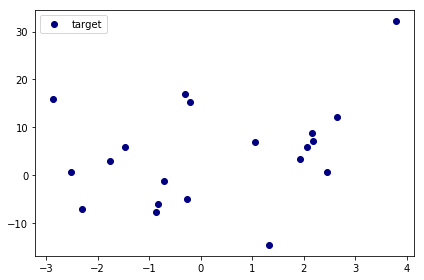

In [21]:
Var = lambda x, dtype=torch.FloatTensor: Variable(torch.from_numpy(x).type(dtype))

x = np.random.uniform(-4, 4, size=BATCH_SIZE).reshape((-1, 1))
noise = np.random.normal(0, 9, size=BATCH_SIZE).reshape((-1, 1))
y = x ** 2 + noise
X = Var(x)
Y = Var(y)

x_test = np.linspace(-5, 5)
y_test = x_test ** 2
X_test = Var(x_test)

plt.scatter(X, Y, c='navy', label='target')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
net = BayesianNetwork(inputSize = 1,\
                      CLASSES = 1, \
                      layers=np.array([100,100]), \
                      activations = np.array(['relu','relu','none']), \
                      SAMPLES = SAMPLES, \
                      BATCH_SIZE = BATCH_SIZE,\
                      NUM_BATCHES = NUM_BATCHES).to(DEVICE)
optimizer = optim.Adam(net.parameters())
for epoch in range(TRAIN_EPOCHS):
    train(net, optimizer,data=X,target=Y)

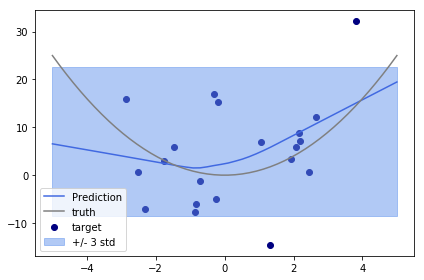

In [25]:
prediction = net.forward(X_test).data.numpy().squeeze(1)
#prediction = [net.forward(X_test).data.numpy().squeeze(1) for _ in range(100)]
#pred = np.array(prediction).T
pred_mean = np.mean(prediction)*np.ones_like(prediction)
pred_std = np.std(prediction)*np.ones_like(prediction)

plt.scatter(x, y, c='navy', label='target')

plt.plot(x_test, prediction, c='royalblue', label='Prediction')
plt.fill_between(x_test, pred_mean - 3 * pred_std, pred_mean + 3 * pred_std,
                     color='cornflowerblue', alpha=.5, label='+/- 3 std')

plt.plot(x_test, y_test, c='grey', label='truth')

plt.legend()
plt.tight_layout()
plt.show()

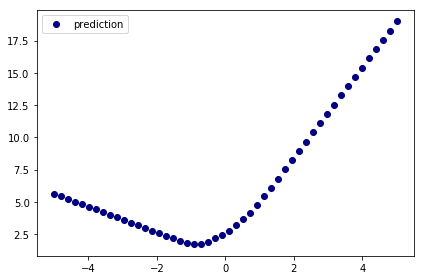

In [23]:
plt.scatter(x_test, prediction, c='navy', label='prediction')
plt.legend()
plt.tight_layout()
plt.show()

# Classification

In [26]:
BATCH_SIZE = 100
TEST_BATCH_SIZE = 5

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './fmnist', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **LOADER_KWARGS)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './fmnist', train=False, download=True,
        transform=transforms.ToTensor()),
    batch_size=TEST_BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

CLASSES = 10
TRAIN_EPOCHS = 20
SAMPLES = 2
TEST_SAMPLES = 10

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

Processing...
Done!


In [28]:
PI = 0.5
SIGMA_1 = torch.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.FloatTensor([math.exp(-6)])

In [29]:
def train(net, optimizer):
    net.train()
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(DEVICE), target.to(DEVICE)
        net.zero_grad()
        loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(data, target)
        loss.backward()
        optimizer.step()
        

In [31]:
net = BayesianNetwork(inputSize = 28*28,\
                      CLASSES = 10, \
                      layers=np.array([400,400]), \
                      activations = np.array(['relu','relu','softmax']), \
                      SAMPLES = SAMPLES, \
                      BATCH_SIZE = BATCH_SIZE,\
                      NUM_BATCHES = NUM_BATCHES).to(DEVICE)

optimizer = optim.Adam(net.parameters())
for epoch in range(TRAIN_EPOCHS):
    train(net, optimizer)

  0%|          | 0/600 [00:00<?, ?it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/600 [00:00<02:23,  4.16it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 2/600 [00:00<02:15,  4.43it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 3/600 [00:00<02:11,  4.56it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use re

  5%|▌         | 31/600 [00:07<02:20,  4.05it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  5%|▌         | 32/600 [00:07<02:18,  4.10it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  6%|▌         | 33/600 [00:07<02:09,  4.38it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  6%|▌         | 34/600 [00:07<02:08,  4.39it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 10%|█         | 62/600 [00:13<01:44,  5.14it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 10%|█         | 63/600 [00:13<01:45,  5.11it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 11%|█         | 64/600 [00:13<01:44,  5.15it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 11%|█         | 65/600 [00:14<01:43,  5.15it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 16%|█▌        | 93/600 [00:19<01:45,  4.82it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 16%|█▌        | 94/600 [00:20<01:44,  4.85it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 16%|█▌        | 95/600 [00:20<01:42,  4.90it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 16%|█▌        | 96/600 [00:20<01:42,  4.93it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 21%|██        | 124/600 [00:25<01:31,  5.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 21%|██        | 125/600 [00:26<01:30,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 21%|██        | 126/600 [00:26<01:30,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 21%|██        | 127/600 [00:26<01:29,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 26%|██▌       | 155/600 [00:32<01:35,  4.68it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 26%|██▌       | 156/600 [00:32<01:37,  4.56it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 26%|██▌       | 157/600 [00:32<01:35,  4.66it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 26%|██▋       | 158/600 [00:32<01:33,  4.75it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 31%|███       | 186/600 [00:38<01:31,  4.54it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 31%|███       | 187/600 [00:39<01:33,  4.41it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 31%|███▏      | 188/600 [00:39<01:34,  4.35it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 32%|███▏      | 189/600 [00:39<01:28,  4.62it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 36%|███▌      | 217/600 [00:44<01:14,  5.16it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 36%|███▋      | 218/600 [00:45<01:14,  5.10it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 36%|███▋      | 219/600 [00:45<01:15,  5.04it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 37%|███▋      | 220/600 [00:45<01:15,  5.06it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 41%|████▏     | 248/600 [00:51<01:14,  4.71it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 42%|████▏     | 249/600 [00:51<01:20,  4.37it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 42%|████▏     | 250/600 [00:51<01:25,  4.08it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 42%|████▏     | 251/600 [00:52<01:28,  3.94it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 46%|████▋     | 279/600 [00:58<01:00,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 47%|████▋     | 280/600 [00:58<01:00,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 47%|████▋     | 281/600 [00:58<00:59,  5.34it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 47%|████▋     | 282/600 [00:58<00:59,  5.36it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 52%|█████▏    | 310/600 [01:03<00:54,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 52%|█████▏    | 311/600 [01:04<00:54,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 52%|█████▏    | 312/600 [01:04<00:54,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 52%|█████▏    | 313/600 [01:04<00:54,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 57%|█████▋    | 341/600 [01:09<00:48,  5.34it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 57%|█████▋    | 342/600 [01:09<00:48,  5.32it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 57%|█████▋    | 343/600 [01:10<00:48,  5.33it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 57%|█████▋    | 344/600 [01:10<00:47,  5.35it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 62%|██████▏   | 372/600 [01:15<00:42,  5.32it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 62%|██████▏   | 373/600 [01:15<00:42,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 62%|██████▏   | 374/600 [01:15<00:42,  5.32it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 62%|██████▎   | 375/600 [01:16<00:42,  5.34it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 67%|██████▋   | 403/600 [01:21<00:37,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 404/600 [01:21<00:37,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 405/600 [01:21<00:37,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 406/600 [01:21<00:36,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 72%|███████▏  | 434/600 [01:27<00:31,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 72%|███████▎  | 435/600 [01:27<00:31,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 73%|███████▎  | 436/600 [01:27<00:30,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 73%|███████▎  | 437/600 [01:27<00:30,  5.32it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 78%|███████▊  | 465/600 [01:33<00:25,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 78%|███████▊  | 466/600 [01:33<00:25,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 78%|███████▊  | 467/600 [01:33<00:25,  5.32it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 78%|███████▊  | 468/600 [01:33<00:24,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 83%|████████▎ | 496/600 [01:38<00:19,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 83%|████████▎ | 497/600 [01:39<00:19,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 83%|████████▎ | 498/600 [01:39<00:19,  5.33it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 83%|████████▎ | 499/600 [01:39<00:18,  5.34it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 88%|████████▊ | 527/600 [01:44<00:13,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 88%|████████▊ | 528/600 [01:44<00:13,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 88%|████████▊ | 529/600 [01:45<00:13,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 88%|████████▊ | 530/600 [01:45<00:13,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 93%|█████████▎| 558/600 [01:50<00:08,  5.08it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 559/600 [01:50<00:08,  5.12it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 560/600 [01:51<00:07,  5.09it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 561/600 [01:51<00:07,  5.13it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 98%|█████████▊| 589/600 [01:56<00:02,  5.13it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 98%|█████████▊| 590/600 [01:56<00:01,  5.12it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 98%|█████████▊| 591/600 [01:57<00:01,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 99%|█████████▊| 592/600 [01:57<00:01,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

  3%|▎         | 20/600 [00:03<01:50,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  4%|▎         | 21/600 [00:04<01:54,  5.05it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  4%|▎         | 22/600 [00:04<01:55,  4.99it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  4%|▍         | 23/600 [00:04<01:56,  4.95it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

  8%|▊         | 51/600 [00:09<01:43,  5.32it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  9%|▊         | 52/600 [00:10<01:43,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  9%|▉         | 53/600 [00:10<01:43,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  9%|▉         | 54/600 [00:10<01:42,  5.32it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 14%|█▎        | 82/600 [00:15<01:37,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 83/600 [00:15<01:37,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 84/600 [00:16<01:37,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 85/600 [00:16<01:37,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 19%|█▉        | 113/600 [00:21<01:31,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 19%|█▉        | 114/600 [00:21<01:31,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 19%|█▉        | 115/600 [00:21<01:31,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 19%|█▉        | 116/600 [00:22<01:31,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 24%|██▍       | 144/600 [00:27<01:26,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 24%|██▍       | 145/600 [00:27<01:26,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 24%|██▍       | 146/600 [00:27<01:25,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 24%|██▍       | 147/600 [00:27<01:26,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 29%|██▉       | 175/600 [00:33<01:20,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 29%|██▉       | 176/600 [00:33<01:20,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 30%|██▉       | 177/600 [00:33<01:20,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 30%|██▉       | 178/600 [00:33<01:20,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 34%|███▍      | 206/600 [00:39<01:14,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 34%|███▍      | 207/600 [00:39<01:14,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 35%|███▍      | 208/600 [00:39<01:14,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 35%|███▍      | 209/600 [00:39<01:13,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 40%|███▉      | 237/600 [00:45<01:08,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 40%|███▉      | 238/600 [00:45<01:08,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 40%|███▉      | 239/600 [00:45<01:08,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 240/600 [00:45<01:07,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 45%|████▍     | 268/600 [00:50<01:03,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 45%|████▍     | 269/600 [00:51<01:03,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 45%|████▌     | 270/600 [00:51<01:03,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 45%|████▌     | 271/600 [00:51<01:03,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 50%|████▉     | 299/600 [00:56<00:56,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 50%|█████     | 300/600 [00:57<00:57,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 50%|█████     | 301/600 [00:57<00:56,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 50%|█████     | 302/600 [00:57<00:56,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 55%|█████▌    | 330/600 [01:02<00:51,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 55%|█████▌    | 331/600 [01:02<00:50,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 55%|█████▌    | 332/600 [01:03<00:50,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 56%|█████▌    | 333/600 [01:03<00:50,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 60%|██████    | 361/600 [01:08<00:45,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 60%|██████    | 362/600 [01:08<00:44,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 60%|██████    | 363/600 [01:08<00:44,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 61%|██████    | 364/600 [01:09<00:44,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 65%|██████▌   | 392/600 [01:14<00:41,  5.05it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 66%|██████▌   | 393/600 [01:14<00:42,  4.89it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 66%|██████▌   | 394/600 [01:14<00:43,  4.73it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 66%|██████▌   | 395/600 [01:15<00:42,  4.80it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 70%|███████   | 423/600 [01:20<00:33,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 71%|███████   | 424/600 [01:20<00:33,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 71%|███████   | 425/600 [01:20<00:33,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 71%|███████   | 426/600 [01:20<00:32,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 76%|███████▌  | 454/600 [01:26<00:27,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 76%|███████▌  | 455/600 [01:26<00:27,  5.32it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 76%|███████▌  | 456/600 [01:26<00:27,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 76%|███████▌  | 457/600 [01:26<00:26,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 81%|████████  | 485/600 [01:32<00:21,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 486/600 [01:32<00:21,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 487/600 [01:32<00:21,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 81%|████████▏ | 488/600 [01:32<00:21,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 86%|████████▌ | 516/600 [01:37<00:15,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 86%|████████▌ | 517/600 [01:38<00:15,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 86%|████████▋ | 518/600 [01:38<00:15,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 86%|████████▋ | 519/600 [01:38<00:15,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 91%|█████████ | 547/600 [01:43<00:10,  5.05it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 91%|█████████▏| 548/600 [01:44<00:10,  5.10it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 92%|█████████▏| 549/600 [01:44<00:09,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 92%|█████████▏| 550/600 [01:44<00:09,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 96%|█████████▋| 578/600 [01:49<00:04,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 96%|█████████▋| 579/600 [01:50<00:04,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 97%|█████████▋| 580/600 [01:50<00:03,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 97%|█████████▋| 581/600 [01:50<00:03,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

  2%|▏         | 9/600 [00:01<01:51,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  2%|▏         | 10/600 [00:01<01:51,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  2%|▏         | 11/600 [00:02<01:50,  5.32it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  2%|▏         | 12/600 [00:02<01:50,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, pl

  7%|▋         | 40/600 [00:07<01:46,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  7%|▋         | 41/600 [00:07<01:45,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  7%|▋         | 42/600 [00:07<01:45,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  7%|▋         | 43/600 [00:08<01:44,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 12%|█▏        | 71/600 [00:13<01:40,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 12%|█▏        | 72/600 [00:13<01:40,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 12%|█▏        | 73/600 [00:13<01:39,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 12%|█▏        | 74/600 [00:13<01:39,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 17%|█▋        | 102/600 [00:19<01:34,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 17%|█▋        | 103/600 [00:19<01:34,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 17%|█▋        | 104/600 [00:19<01:34,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 18%|█▊        | 105/600 [00:19<01:33,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 22%|██▏       | 133/600 [00:25<01:28,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 22%|██▏       | 134/600 [00:25<01:27,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 22%|██▎       | 135/600 [00:25<01:27,  5.32it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 23%|██▎       | 136/600 [00:25<01:27,  5.32it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 27%|██▋       | 164/600 [00:30<01:22,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 165/600 [00:31<01:22,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 166/600 [00:31<01:22,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 167/600 [00:31<01:22,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 32%|███▎      | 195/600 [00:36<01:16,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 33%|███▎      | 196/600 [00:36<01:16,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 33%|███▎      | 197/600 [00:37<01:16,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 33%|███▎      | 198/600 [00:37<01:16,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 38%|███▊      | 226/600 [00:42<01:15,  4.93it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 38%|███▊      | 227/600 [00:43<01:14,  5.02it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 38%|███▊      | 228/600 [00:43<01:16,  4.83it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 38%|███▊      | 229/600 [00:43<01:19,  4.65it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 43%|████▎     | 257/600 [00:49<01:19,  4.34it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 43%|████▎     | 258/600 [00:50<01:18,  4.33it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 43%|████▎     | 259/600 [00:50<01:18,  4.35it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 43%|████▎     | 260/600 [00:50<01:19,  4.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 48%|████▊     | 288/600 [00:56<01:09,  4.46it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 48%|████▊     | 289/600 [00:57<01:09,  4.50it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 48%|████▊     | 290/600 [00:57<01:11,  4.33it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 48%|████▊     | 291/600 [00:57<01:10,  4.38it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 53%|█████▎    | 319/600 [01:03<00:58,  4.81it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 53%|█████▎    | 320/600 [01:04<00:57,  4.89it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 321/600 [01:04<00:55,  5.02it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 322/600 [01:04<00:54,  5.07it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 58%|█████▊    | 350/600 [01:09<00:47,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 58%|█████▊    | 351/600 [01:09<00:47,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 59%|█████▊    | 352/600 [01:10<00:46,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 59%|█████▉    | 353/600 [01:10<00:46,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 64%|██████▎   | 381/600 [01:15<00:41,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 64%|██████▎   | 382/600 [01:15<00:41,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 64%|██████▍   | 383/600 [01:15<00:40,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 64%|██████▍   | 384/600 [01:16<00:40,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 69%|██████▊   | 412/600 [01:21<00:35,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 69%|██████▉   | 413/600 [01:21<00:35,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 69%|██████▉   | 414/600 [01:21<00:34,  5.32it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 69%|██████▉   | 415/600 [01:22<00:34,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 74%|███████▍  | 443/600 [01:27<00:29,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 74%|███████▍  | 444/600 [01:27<00:29,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 74%|███████▍  | 445/600 [01:27<00:29,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 74%|███████▍  | 446/600 [01:27<00:29,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 79%|███████▉  | 474/600 [01:34<00:28,  4.41it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 79%|███████▉  | 475/600 [01:34<00:28,  4.39it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 79%|███████▉  | 476/600 [01:34<00:28,  4.39it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 80%|███████▉  | 477/600 [01:34<00:28,  4.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 84%|████████▍ | 505/600 [01:41<00:20,  4.71it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 84%|████████▍ | 506/600 [01:41<00:19,  4.83it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 84%|████████▍ | 507/600 [01:41<00:18,  4.96it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 85%|████████▍ | 508/600 [01:41<00:19,  4.68it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 89%|████████▉ | 536/600 [01:48<00:14,  4.49it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 90%|████████▉ | 537/600 [01:48<00:14,  4.33it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 90%|████████▉ | 538/600 [01:48<00:14,  4.37it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 90%|████████▉ | 539/600 [01:48<00:13,  4.38it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 94%|█████████▍| 567/600 [01:54<00:06,  5.10it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 95%|█████████▍| 568/600 [01:55<00:06,  5.15it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 95%|█████████▍| 569/600 [01:55<00:06,  5.13it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 95%|█████████▌| 570/600 [01:55<00:06,  4.96it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

100%|█████████▉| 598/600 [02:01<00:00,  4.93it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|█████████▉| 599/600 [02:01<00:00,  5.01it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/600 [00:00<?, ?it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/600 [00:00<01:54,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please us

  5%|▍         | 29/600 [00:05<01:48,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  5%|▌         | 30/600 [00:05<01:48,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  5%|▌         | 31/600 [00:05<01:48,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  5%|▌         | 32/600 [00:06<01:47,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 10%|█         | 60/600 [00:12<02:14,  4.01it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 10%|█         | 61/600 [00:12<02:14,  4.01it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 10%|█         | 62/600 [00:12<02:18,  3.90it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 10%|█         | 63/600 [00:12<02:17,  3.89it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 15%|█▌        | 91/600 [00:18<01:36,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 15%|█▌        | 92/600 [00:18<01:36,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 16%|█▌        | 93/600 [00:19<01:36,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 16%|█▌        | 94/600 [00:19<01:36,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 20%|██        | 122/600 [00:24<01:31,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 20%|██        | 123/600 [00:24<01:30,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 21%|██        | 124/600 [00:24<01:30,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 21%|██        | 125/600 [00:25<01:30,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 26%|██▌       | 153/600 [00:30<01:25,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 26%|██▌       | 154/600 [00:30<01:24,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 26%|██▌       | 155/600 [00:30<01:25,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 26%|██▌       | 156/600 [00:31<01:25,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 31%|███       | 184/600 [00:36<01:24,  4.93it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 31%|███       | 185/600 [00:36<01:24,  4.88it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 31%|███       | 186/600 [00:36<01:26,  4.77it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 31%|███       | 187/600 [00:37<01:30,  4.58it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 36%|███▌      | 215/600 [00:43<01:22,  4.66it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 36%|███▌      | 216/600 [00:43<01:22,  4.66it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 36%|███▌      | 217/600 [00:43<01:22,  4.64it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 36%|███▋      | 218/600 [00:43<01:21,  4.66it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 41%|████      | 246/600 [00:49<01:08,  5.15it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 247/600 [00:49<01:08,  5.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 248/600 [00:50<01:07,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 42%|████▏     | 249/600 [00:50<01:07,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 46%|████▌     | 277/600 [00:55<01:01,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 46%|████▋     | 278/600 [00:55<01:01,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 46%|████▋     | 279/600 [00:56<01:01,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 47%|████▋     | 280/600 [00:56<01:01,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 51%|█████▏    | 308/600 [01:01<00:55,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 52%|█████▏    | 309/600 [01:01<00:55,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 52%|█████▏    | 310/600 [01:02<00:55,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 52%|█████▏    | 311/600 [01:02<00:55,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 56%|█████▋    | 339/600 [01:07<00:53,  4.85it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 57%|█████▋    | 340/600 [01:08<00:52,  4.91it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 57%|█████▋    | 341/600 [01:08<00:53,  4.89it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 57%|█████▋    | 342/600 [01:08<00:51,  4.97it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 62%|██████▏   | 370/600 [01:13<00:43,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 62%|██████▏   | 371/600 [01:14<00:43,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 62%|██████▏   | 372/600 [01:14<00:43,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 62%|██████▏   | 373/600 [01:14<00:43,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 67%|██████▋   | 401/600 [01:19<00:38,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 402/600 [01:19<00:37,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 403/600 [01:20<00:37,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 404/600 [01:20<00:37,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 72%|███████▏  | 432/600 [01:25<00:32,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 72%|███████▏  | 433/600 [01:25<00:31,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 72%|███████▏  | 434/600 [01:26<00:31,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 72%|███████▎  | 435/600 [01:26<00:31,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 77%|███████▋  | 463/600 [01:31<00:26,  5.15it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 77%|███████▋  | 464/600 [01:31<00:26,  5.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 78%|███████▊  | 465/600 [01:32<00:26,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 78%|███████▊  | 466/600 [01:32<00:25,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 82%|████████▏ | 494/600 [01:37<00:20,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 82%|████████▎ | 495/600 [01:37<00:20,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 83%|████████▎ | 496/600 [01:38<00:19,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 83%|████████▎ | 497/600 [01:38<00:20,  5.08it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 88%|████████▊ | 525/600 [01:43<00:14,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 88%|████████▊ | 526/600 [01:43<00:14,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 88%|████████▊ | 527/600 [01:44<00:14,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 88%|████████▊ | 528/600 [01:44<00:13,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 93%|█████████▎| 556/600 [01:50<00:10,  4.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 557/600 [01:50<00:09,  4.36it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 558/600 [01:50<00:09,  4.54it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 559/600 [01:50<00:09,  4.50it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 98%|█████████▊| 587/600 [01:56<00:02,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 98%|█████████▊| 588/600 [01:56<00:02,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 98%|█████████▊| 589/600 [01:56<00:02,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 98%|█████████▊| 590/600 [01:56<00:01,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

  3%|▎         | 18/600 [00:03<01:52,  5.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  3%|▎         | 19/600 [00:03<01:51,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  3%|▎         | 20/600 [00:03<01:51,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  4%|▎         | 21/600 [00:04<01:51,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

  8%|▊         | 49/600 [00:09<01:46,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  8%|▊         | 50/600 [00:09<01:46,  5.16it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  8%|▊         | 51/600 [00:09<01:46,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  9%|▊         | 52/600 [00:10<01:46,  5.16it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 13%|█▎        | 80/600 [00:15<01:41,  5.15it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 14%|█▎        | 81/600 [00:15<01:40,  5.16it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 14%|█▎        | 82/600 [00:15<01:40,  5.15it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 83/600 [00:16<01:40,  5.16it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 18%|█▊        | 111/600 [00:21<01:42,  4.77it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 19%|█▊        | 112/600 [00:21<01:41,  4.81it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 19%|█▉        | 113/600 [00:21<01:39,  4.89it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 19%|█▉        | 114/600 [00:22<01:37,  4.99it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 24%|██▎       | 142/600 [00:27<01:27,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 24%|██▍       | 143/600 [00:27<01:27,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 24%|██▍       | 144/600 [00:27<01:26,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 24%|██▍       | 145/600 [00:28<01:26,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 29%|██▉       | 173/600 [00:33<01:22,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 29%|██▉       | 174/600 [00:33<01:22,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 29%|██▉       | 175/600 [00:33<01:22,  5.13it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 29%|██▉       | 176/600 [00:34<01:23,  5.07it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 34%|███▍      | 204/600 [00:39<01:15,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 34%|███▍      | 205/600 [00:39<01:15,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 34%|███▍      | 206/600 [00:39<01:15,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 34%|███▍      | 207/600 [00:40<01:15,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 39%|███▉      | 235/600 [00:45<01:13,  4.98it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 39%|███▉      | 236/600 [00:45<01:12,  5.00it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 40%|███▉      | 237/600 [00:45<01:11,  5.06it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 40%|███▉      | 238/600 [00:46<01:10,  5.12it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 44%|████▍     | 266/600 [00:51<01:04,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 44%|████▍     | 267/600 [00:51<01:04,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 45%|████▍     | 268/600 [00:51<01:04,  5.15it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 45%|████▍     | 269/600 [00:51<01:03,  5.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 50%|████▉     | 297/600 [00:57<00:58,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 50%|████▉     | 298/600 [00:57<00:58,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 50%|████▉     | 299/600 [00:57<00:57,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 50%|█████     | 300/600 [00:57<00:57,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 55%|█████▍    | 328/600 [01:03<00:52,  5.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 55%|█████▍    | 329/600 [01:03<00:52,  5.15it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 55%|█████▌    | 330/600 [01:03<00:52,  5.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 55%|█████▌    | 331/600 [01:03<00:51,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 60%|█████▉    | 359/600 [01:09<00:46,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 60%|██████    | 360/600 [01:09<00:45,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 60%|██████    | 361/600 [01:09<00:45,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 60%|██████    | 362/600 [01:09<00:45,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 65%|██████▌   | 390/600 [01:15<00:40,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 65%|██████▌   | 391/600 [01:15<00:40,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 65%|██████▌   | 392/600 [01:15<00:39,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 66%|██████▌   | 393/600 [01:15<00:39,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 70%|███████   | 421/600 [01:21<00:34,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 70%|███████   | 422/600 [01:21<00:34,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 70%|███████   | 423/600 [01:21<00:33,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 71%|███████   | 424/600 [01:21<00:33,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 75%|███████▌  | 452/600 [01:27<00:28,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 76%|███████▌  | 453/600 [01:27<00:28,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 76%|███████▌  | 454/600 [01:27<00:27,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 76%|███████▌  | 455/600 [01:27<00:27,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 80%|████████  | 483/600 [01:32<00:22,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 484/600 [01:33<00:22,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 485/600 [01:33<00:22,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 486/600 [01:33<00:21,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 86%|████████▌ | 514/600 [01:38<00:16,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 86%|████████▌ | 515/600 [01:39<00:16,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 86%|████████▌ | 516/600 [01:39<00:16,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 86%|████████▌ | 517/600 [01:39<00:15,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 91%|█████████ | 545/600 [01:44<00:10,  5.13it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 91%|█████████ | 546/600 [01:45<00:10,  5.13it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 91%|█████████ | 547/600 [01:45<00:10,  5.14it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 91%|█████████▏| 548/600 [01:45<00:10,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 96%|█████████▌| 576/600 [01:50<00:04,  5.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 96%|█████████▌| 577/600 [01:51<00:04,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 96%|█████████▋| 578/600 [01:51<00:04,  5.11it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 96%|█████████▋| 579/600 [01:51<00:04,  5.14it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

  1%|          | 7/600 [00:01<01:53,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 8/600 [00:01<01:53,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  2%|▏         | 9/600 [00:01<01:52,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  2%|▏         | 10/600 [00:01<01:52,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, plea

  6%|▋         | 38/600 [00:07<01:47,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  6%|▋         | 39/600 [00:07<01:46,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  7%|▋         | 40/600 [00:07<01:46,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  7%|▋         | 41/600 [00:07<01:46,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 12%|█▏        | 69/600 [00:13<01:42,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 12%|█▏        | 70/600 [00:13<01:41,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 12%|█▏        | 71/600 [00:13<01:40,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 12%|█▏        | 72/600 [00:13<01:40,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 17%|█▋        | 100/600 [00:19<01:37,  5.13it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 17%|█▋        | 101/600 [00:19<01:37,  5.11it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 17%|█▋        | 102/600 [00:19<01:38,  5.07it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 17%|█▋        | 103/600 [00:19<01:38,  5.05it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 22%|██▏       | 131/600 [00:25<01:30,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 22%|██▏       | 132/600 [00:25<01:29,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 22%|██▏       | 133/600 [00:25<01:28,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 22%|██▏       | 134/600 [00:25<01:28,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 27%|██▋       | 162/600 [00:31<01:23,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 163/600 [00:31<01:23,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 164/600 [00:31<01:23,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 165/600 [00:31<01:22,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 32%|███▏      | 193/600 [00:36<01:17,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 32%|███▏      | 194/600 [00:37<01:17,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 32%|███▎      | 195/600 [00:37<01:17,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 33%|███▎      | 196/600 [00:37<01:16,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 37%|███▋      | 224/600 [00:42<01:12,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 38%|███▊      | 225/600 [00:43<01:11,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 38%|███▊      | 226/600 [00:43<01:11,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 38%|███▊      | 227/600 [00:43<01:11,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 42%|████▎     | 255/600 [00:48<01:06,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 43%|████▎     | 256/600 [00:48<01:05,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 43%|████▎     | 257/600 [00:49<01:05,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 43%|████▎     | 258/600 [00:49<01:05,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 48%|████▊     | 286/600 [00:54<01:00,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 48%|████▊     | 287/600 [00:54<00:59,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 48%|████▊     | 288/600 [00:55<00:59,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 48%|████▊     | 289/600 [00:55<00:59,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 53%|█████▎    | 317/600 [01:00<00:54,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 53%|█████▎    | 318/600 [01:00<00:53,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 53%|█████▎    | 319/600 [01:00<00:53,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 53%|█████▎    | 320/600 [01:01<00:53,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 58%|█████▊    | 348/600 [01:06<00:48,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 58%|█████▊    | 349/600 [01:06<00:47,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 58%|█████▊    | 350/600 [01:06<00:47,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 58%|█████▊    | 351/600 [01:07<00:47,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 63%|██████▎   | 379/600 [01:12<00:42,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 63%|██████▎   | 380/600 [01:12<00:42,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 64%|██████▎   | 381/600 [01:12<00:41,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 64%|██████▎   | 382/600 [01:13<00:41,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 68%|██████▊   | 410/600 [01:18<00:36,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 411/600 [01:18<00:36,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 69%|██████▊   | 412/600 [01:18<00:35,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 69%|██████▉   | 413/600 [01:18<00:35,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 74%|███████▎  | 441/600 [01:24<00:30,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 74%|███████▎  | 442/600 [01:24<00:30,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 74%|███████▍  | 443/600 [01:24<00:30,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 74%|███████▍  | 444/600 [01:24<00:29,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 79%|███████▊  | 472/600 [01:30<00:24,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 79%|███████▉  | 473/600 [01:30<00:24,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 79%|███████▉  | 474/600 [01:30<00:24,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 79%|███████▉  | 475/600 [01:30<00:23,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 84%|████████▍ | 503/600 [01:36<00:18,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 84%|████████▍ | 504/600 [01:36<00:18,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 84%|████████▍ | 505/600 [01:36<00:18,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 84%|████████▍ | 506/600 [01:36<00:17,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 89%|████████▉ | 534/600 [01:42<00:12,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 89%|████████▉ | 535/600 [01:42<00:12,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 89%|████████▉ | 536/600 [01:42<00:12,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 90%|████████▉ | 537/600 [01:42<00:11,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 94%|█████████▍| 565/600 [01:47<00:06,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 566/600 [01:48<00:06,  5.16it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 567/600 [01:48<00:06,  5.15it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 95%|█████████▍| 568/600 [01:48<00:06,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 99%|█████████▉| 596/600 [01:53<00:00,  4.85it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|█████████▉| 597/600 [01:54<00:00,  4.95it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|█████████▉| 598/600 [01:54<00:00,  5.00it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|█████████▉| 599/600 [01:54<00:00,  5.08it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

  4%|▍         | 27/600 [00:05<01:49,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  5%|▍         | 28/600 [00:05<01:49,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  5%|▍         | 29/600 [00:05<01:49,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  5%|▌         | 30/600 [00:05<01:48,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 10%|▉         | 58/600 [00:11<01:43,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 10%|▉         | 59/600 [00:11<01:43,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 10%|█         | 60/600 [00:11<01:42,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 10%|█         | 61/600 [00:11<01:42,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 15%|█▍        | 89/600 [00:17<01:41,  5.04it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 15%|█▌        | 90/600 [00:17<01:40,  5.09it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 15%|█▌        | 91/600 [00:17<01:38,  5.15it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 15%|█▌        | 92/600 [00:17<01:38,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 20%|██        | 120/600 [00:23<01:33,  5.13it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 20%|██        | 121/600 [00:23<01:33,  5.10it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 20%|██        | 122/600 [00:23<01:33,  5.09it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 20%|██        | 123/600 [00:23<01:34,  5.05it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 25%|██▌       | 151/600 [00:29<01:27,  5.11it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 25%|██▌       | 152/600 [00:29<01:26,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 26%|██▌       | 153/600 [00:29<01:25,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 26%|██▌       | 154/600 [00:29<01:25,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 30%|███       | 182/600 [00:35<01:22,  5.06it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 30%|███       | 183/600 [00:35<01:22,  5.05it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 31%|███       | 184/600 [00:35<01:22,  5.04it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 31%|███       | 185/600 [00:35<01:22,  5.04it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 36%|███▌      | 213/600 [00:40<01:14,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 36%|███▌      | 214/600 [00:41<01:13,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 36%|███▌      | 215/600 [00:41<01:13,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 36%|███▌      | 216/600 [00:41<01:13,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 41%|████      | 244/600 [00:47<01:11,  4.97it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 245/600 [00:47<01:11,  4.95it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 246/600 [00:47<01:11,  4.96it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 247/600 [00:47<01:11,  4.97it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 46%|████▌     | 275/600 [00:53<01:02,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 46%|████▌     | 276/600 [00:53<01:02,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 46%|████▌     | 277/600 [00:53<01:02,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 46%|████▋     | 278/600 [00:53<01:01,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 51%|█████     | 306/600 [00:59<00:56,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 51%|█████     | 307/600 [00:59<00:55,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 51%|█████▏    | 308/600 [00:59<00:55,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 52%|█████▏    | 309/600 [00:59<00:55,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 56%|█████▌    | 337/600 [01:05<00:51,  5.12it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 56%|█████▋    | 338/600 [01:05<00:50,  5.16it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 56%|█████▋    | 339/600 [01:05<00:50,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 57%|█████▋    | 340/600 [01:05<00:49,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 61%|██████▏   | 368/600 [01:11<00:44,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 62%|██████▏   | 369/600 [01:11<00:44,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 62%|██████▏   | 370/600 [01:11<00:43,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 62%|██████▏   | 371/600 [01:11<00:43,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 66%|██████▋   | 399/600 [01:17<00:38,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 400/600 [01:17<00:38,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 401/600 [01:17<00:37,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 402/600 [01:17<00:37,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 72%|███████▏  | 430/600 [01:23<00:32,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 72%|███████▏  | 431/600 [01:23<00:32,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 72%|███████▏  | 432/600 [01:23<00:32,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 72%|███████▏  | 433/600 [01:23<00:31,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 77%|███████▋  | 461/600 [01:28<00:26,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 77%|███████▋  | 462/600 [01:29<00:26,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 77%|███████▋  | 463/600 [01:29<00:26,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 77%|███████▋  | 464/600 [01:29<00:26,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 82%|████████▏ | 492/600 [01:34<00:20,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 82%|████████▏ | 493/600 [01:35<00:20,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 82%|████████▏ | 494/600 [01:35<00:20,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 82%|████████▎ | 495/600 [01:35<00:20,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 87%|████████▋ | 523/600 [01:40<00:14,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 87%|████████▋ | 524/600 [01:40<00:14,  5.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 88%|████████▊ | 525/600 [01:41<00:14,  5.14it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 88%|████████▊ | 526/600 [01:41<00:14,  5.09it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 92%|█████████▏| 554/600 [01:46<00:08,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 92%|█████████▎| 555/600 [01:46<00:08,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 556/600 [01:47<00:08,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 557/600 [01:47<00:08,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 98%|█████████▊| 585/600 [01:52<00:02,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 98%|█████████▊| 586/600 [01:52<00:02,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 98%|█████████▊| 587/600 [01:53<00:02,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 98%|█████████▊| 588/600 [01:53<00:02,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

  3%|▎         | 16/600 [00:03<01:51,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  3%|▎         | 17/600 [00:03<01:54,  5.11it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  3%|▎         | 18/600 [00:03<01:56,  5.01it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  3%|▎         | 19/600 [00:03<01:55,  5.05it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

  8%|▊         | 47/600 [00:09<01:45,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  8%|▊         | 48/600 [00:09<01:45,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  8%|▊         | 49/600 [00:09<01:45,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  8%|▊         | 50/600 [00:09<01:44,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 13%|█▎        | 78/600 [00:15<01:39,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 13%|█▎        | 79/600 [00:15<01:39,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 13%|█▎        | 80/600 [00:15<01:38,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 14%|█▎        | 81/600 [00:15<01:38,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 18%|█▊        | 109/600 [00:20<01:33,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 18%|█▊        | 110/600 [00:21<01:33,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 18%|█▊        | 111/600 [00:21<01:33,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 19%|█▊        | 112/600 [00:21<01:32,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 23%|██▎       | 140/600 [00:26<01:28,  5.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 24%|██▎       | 141/600 [00:27<01:28,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 24%|██▎       | 142/600 [00:27<01:28,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 24%|██▍       | 143/600 [00:27<01:27,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 28%|██▊       | 171/600 [00:32<01:26,  4.98it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 29%|██▊       | 172/600 [00:33<01:25,  4.99it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 29%|██▉       | 173/600 [00:33<01:25,  5.02it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 29%|██▉       | 174/600 [00:33<01:24,  5.05it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 34%|███▎      | 202/600 [00:38<01:15,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 34%|███▍      | 203/600 [00:39<01:15,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 34%|███▍      | 204/600 [00:39<01:15,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 34%|███▍      | 205/600 [00:39<01:15,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 39%|███▉      | 233/600 [00:44<01:09,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 39%|███▉      | 234/600 [00:45<01:09,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 39%|███▉      | 235/600 [00:45<01:09,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 39%|███▉      | 236/600 [00:45<01:09,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 44%|████▍     | 264/600 [00:50<01:04,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 44%|████▍     | 265/600 [00:50<01:03,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 44%|████▍     | 266/600 [00:51<01:03,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 44%|████▍     | 267/600 [00:51<01:03,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 49%|████▉     | 295/600 [00:56<00:58,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 49%|████▉     | 296/600 [00:56<00:57,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 50%|████▉     | 297/600 [00:57<00:57,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 50%|████▉     | 298/600 [00:57<00:57,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 54%|█████▍    | 326/600 [01:02<00:52,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 55%|█████▍    | 327/600 [01:02<00:51,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 55%|█████▍    | 328/600 [01:02<00:51,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 55%|█████▍    | 329/600 [01:03<00:51,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 60%|█████▉    | 357/600 [01:08<00:46,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 60%|█████▉    | 358/600 [01:08<00:46,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 60%|█████▉    | 359/600 [01:08<00:45,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 60%|██████    | 360/600 [01:09<00:45,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 65%|██████▍   | 388/600 [01:14<00:40,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 65%|██████▍   | 389/600 [01:14<00:40,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 65%|██████▌   | 390/600 [01:14<00:40,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 65%|██████▌   | 391/600 [01:14<00:39,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 70%|██████▉   | 419/600 [01:20<00:34,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 70%|███████   | 420/600 [01:20<00:34,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 70%|███████   | 421/600 [01:20<00:34,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 70%|███████   | 422/600 [01:20<00:33,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 75%|███████▌  | 450/600 [01:26<00:28,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 75%|███████▌  | 451/600 [01:26<00:28,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 75%|███████▌  | 452/600 [01:26<00:28,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 76%|███████▌  | 453/600 [01:26<00:28,  5.16it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 80%|████████  | 481/600 [01:32<00:22,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 482/600 [01:32<00:22,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 483/600 [01:32<00:22,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 484/600 [01:32<00:22,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 85%|████████▌ | 512/600 [01:38<00:16,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 86%|████████▌ | 513/600 [01:38<00:16,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 86%|████████▌ | 514/600 [01:38<00:16,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 86%|████████▌ | 515/600 [01:38<00:16,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 90%|█████████ | 543/600 [01:44<00:10,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 91%|█████████ | 544/600 [01:44<00:10,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 91%|█████████ | 545/600 [01:44<00:10,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 91%|█████████ | 546/600 [01:44<00:10,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 96%|█████████▌| 574/600 [01:49<00:04,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 96%|█████████▌| 575/600 [01:50<00:04,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 96%|█████████▌| 576/600 [01:50<00:04,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 96%|█████████▌| 577/600 [01:50<00:04,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

  1%|          | 5/600 [00:00<01:54,  5.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  1%|          | 6/600 [00:01<01:53,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  1%|          | 7/600 [00:01<01:53,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 8/600 [00:01<01:52,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, pleas

  6%|▌         | 36/600 [00:06<01:50,  5.12it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  6%|▌         | 37/600 [00:07<01:48,  5.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  6%|▋         | 38/600 [00:07<01:47,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  6%|▋         | 39/600 [00:07<01:47,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 11%|█         | 67/600 [00:12<01:40,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 11%|█▏        | 68/600 [00:13<01:41,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 12%|█▏        | 69/600 [00:13<01:40,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 12%|█▏        | 70/600 [00:13<01:40,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 16%|█▋        | 98/600 [00:19<01:37,  5.13it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 16%|█▋        | 99/600 [00:19<01:36,  5.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 17%|█▋        | 100/600 [00:19<01:35,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 17%|█▋        | 101/600 [00:19<01:35,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated,

 22%|██▏       | 129/600 [00:24<01:30,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 22%|██▏       | 130/600 [00:25<01:29,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 22%|██▏       | 131/600 [00:25<01:29,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 22%|██▏       | 132/600 [00:25<01:28,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 27%|██▋       | 160/600 [00:30<01:24,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 161/600 [00:31<01:23,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 162/600 [00:31<01:23,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 163/600 [00:31<01:23,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 32%|███▏      | 191/600 [00:36<01:22,  4.98it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 32%|███▏      | 192/600 [00:37<01:21,  5.01it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 32%|███▏      | 193/600 [00:37<01:21,  5.01it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 32%|███▏      | 194/600 [00:37<01:20,  5.04it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 37%|███▋      | 222/600 [00:43<01:12,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 37%|███▋      | 223/600 [00:43<01:11,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 37%|███▋      | 224/600 [00:43<01:11,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 38%|███▊      | 225/600 [00:43<01:11,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 42%|████▏     | 253/600 [00:48<01:06,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 42%|████▏     | 254/600 [00:49<01:06,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 42%|████▎     | 255/600 [00:49<01:05,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 43%|████▎     | 256/600 [00:49<01:05,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 47%|████▋     | 284/600 [00:54<01:00,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 48%|████▊     | 285/600 [00:55<01:00,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 48%|████▊     | 286/600 [00:55<00:59,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 48%|████▊     | 287/600 [00:55<00:59,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 52%|█████▎    | 315/600 [01:00<00:56,  5.05it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 53%|█████▎    | 316/600 [01:01<00:55,  5.09it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 53%|█████▎    | 317/600 [01:01<00:55,  5.12it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 53%|█████▎    | 318/600 [01:01<00:55,  5.12it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 58%|█████▊    | 346/600 [01:07<00:49,  5.11it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 58%|█████▊    | 347/600 [01:07<00:49,  5.16it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 58%|█████▊    | 348/600 [01:07<00:49,  5.13it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 58%|█████▊    | 349/600 [01:07<00:49,  5.11it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 63%|██████▎   | 377/600 [01:13<00:44,  5.06it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 63%|██████▎   | 378/600 [01:13<00:43,  5.13it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 63%|██████▎   | 379/600 [01:13<00:42,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 63%|██████▎   | 380/600 [01:13<00:42,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 68%|██████▊   | 408/600 [01:18<00:36,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 409/600 [01:19<00:36,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 410/600 [01:19<00:36,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 411/600 [01:19<00:35,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 73%|███████▎  | 439/600 [01:24<00:31,  5.07it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 73%|███████▎  | 440/600 [01:25<00:31,  5.08it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 74%|███████▎  | 441/600 [01:25<00:31,  5.05it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 74%|███████▎  | 442/600 [01:25<00:31,  5.09it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 78%|███████▊  | 470/600 [01:30<00:24,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 78%|███████▊  | 471/600 [01:31<00:24,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 79%|███████▊  | 472/600 [01:31<00:24,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 79%|███████▉  | 473/600 [01:31<00:24,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 84%|████████▎ | 501/600 [01:36<00:18,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 84%|████████▎ | 502/600 [01:36<00:18,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 84%|████████▍ | 503/600 [01:37<00:18,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 84%|████████▍ | 504/600 [01:37<00:18,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 89%|████████▊ | 532/600 [01:42<00:12,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 89%|████████▉ | 533/600 [01:42<00:12,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 89%|████████▉ | 534/600 [01:43<00:12,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 89%|████████▉ | 535/600 [01:43<00:12,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 94%|█████████▍| 563/600 [01:48<00:07,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 564/600 [01:48<00:06,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 565/600 [01:48<00:06,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 566/600 [01:49<00:06,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 99%|█████████▉| 594/600 [01:54<00:01,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 99%|█████████▉| 595/600 [01:54<00:00,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 99%|█████████▉| 596/600 [01:54<00:00,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|█████████▉| 597/600 [01:54<00:00,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

  4%|▍         | 25/600 [00:04<01:48,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  4%|▍         | 26/600 [00:04<01:48,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  4%|▍         | 27/600 [00:05<01:48,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  5%|▍         | 28/600 [00:05<01:48,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

  9%|▉         | 56/600 [00:10<01:42,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 10%|▉         | 57/600 [00:10<01:42,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 10%|▉         | 58/600 [00:10<01:42,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 10%|▉         | 59/600 [00:11<01:42,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 14%|█▍        | 87/600 [00:16<01:49,  4.71it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 88/600 [00:17<02:15,  3.77it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 89/600 [00:17<02:09,  3.94it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 15%|█▌        | 90/600 [00:17<02:04,  4.09it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 20%|█▉        | 118/600 [00:23<01:30,  5.35it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 20%|█▉        | 119/600 [00:23<01:29,  5.36it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 20%|██        | 120/600 [00:24<01:29,  5.38it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 20%|██        | 121/600 [00:24<01:28,  5.39it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 25%|██▍       | 149/600 [00:29<01:24,  5.36it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 25%|██▌       | 150/600 [00:29<01:23,  5.37it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 25%|██▌       | 151/600 [00:29<01:23,  5.38it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 25%|██▌       | 152/600 [00:30<01:23,  5.39it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 30%|███       | 180/600 [00:35<01:17,  5.40it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 30%|███       | 181/600 [00:35<01:17,  5.39it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 30%|███       | 182/600 [00:35<01:17,  5.40it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 30%|███       | 183/600 [00:35<01:17,  5.41it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 35%|███▌      | 211/600 [00:41<01:15,  5.14it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 35%|███▌      | 212/600 [00:41<01:15,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 36%|███▌      | 213/600 [00:41<01:14,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 36%|███▌      | 214/600 [00:41<01:14,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 40%|████      | 242/600 [00:47<01:14,  4.83it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 243/600 [00:47<01:15,  4.70it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 244/600 [00:47<01:15,  4.73it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 245/600 [00:47<01:13,  4.83it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 46%|████▌     | 273/600 [00:55<01:30,  3.61it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 46%|████▌     | 274/600 [00:55<01:31,  3.55it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 46%|████▌     | 275/600 [00:55<01:24,  3.84it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 46%|████▌     | 276/600 [00:55<01:18,  4.11it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 51%|█████     | 304/600 [01:02<01:02,  4.72it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 51%|█████     | 305/600 [01:02<01:03,  4.67it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 51%|█████     | 306/600 [01:02<01:03,  4.65it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 51%|█████     | 307/600 [01:02<01:03,  4.64it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 56%|█████▌    | 335/600 [01:08<00:55,  4.81it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 56%|█████▌    | 336/600 [01:08<00:53,  4.92it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 56%|█████▌    | 337/600 [01:09<00:54,  4.80it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 56%|█████▋    | 338/600 [01:09<00:58,  4.50it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 61%|██████    | 366/600 [01:15<00:47,  4.93it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 61%|██████    | 367/600 [01:15<00:46,  5.02it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 61%|██████▏   | 368/600 [01:15<00:45,  5.08it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 62%|██████▏   | 369/600 [01:15<00:45,  5.11it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 66%|██████▌   | 397/600 [01:21<00:41,  4.91it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 66%|██████▋   | 398/600 [01:21<00:40,  5.02it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 66%|██████▋   | 399/600 [01:21<00:39,  5.04it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 400/600 [01:22<00:39,  5.05it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 71%|███████▏  | 428/600 [01:27<00:33,  5.15it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 72%|███████▏  | 429/600 [01:28<00:35,  4.87it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 72%|███████▏  | 430/600 [01:28<00:36,  4.67it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 72%|███████▏  | 431/600 [01:28<00:36,  4.62it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 76%|███████▋  | 459/600 [01:33<00:26,  5.34it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 77%|███████▋  | 460/600 [01:34<00:26,  5.37it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 77%|███████▋  | 461/600 [01:34<00:25,  5.35it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 77%|███████▋  | 462/600 [01:34<00:25,  5.35it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 82%|████████▏ | 490/600 [01:39<00:20,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 82%|████████▏ | 491/600 [01:39<00:20,  5.33it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 82%|████████▏ | 492/600 [01:40<00:20,  5.33it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 82%|████████▏ | 493/600 [01:40<00:20,  5.34it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 87%|████████▋ | 521/600 [01:45<00:15,  5.12it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 87%|████████▋ | 522/600 [01:46<00:15,  5.13it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 87%|████████▋ | 523/600 [01:46<00:14,  5.15it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 87%|████████▋ | 524/600 [01:46<00:14,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 92%|█████████▏| 552/600 [01:51<00:08,  5.34it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 92%|█████████▏| 553/600 [01:51<00:08,  5.33it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 92%|█████████▏| 554/600 [01:52<00:08,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 92%|█████████▎| 555/600 [01:52<00:09,  4.68it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 97%|█████████▋| 583/600 [01:58<00:03,  5.13it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 97%|█████████▋| 584/600 [01:58<00:03,  5.09it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 98%|█████████▊| 585/600 [01:58<00:02,  5.12it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 98%|█████████▊| 586/600 [01:58<00:02,  5.09it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

  2%|▏         | 14/600 [00:02<01:56,  5.04it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  2%|▎         | 15/600 [00:02<01:55,  5.05it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  3%|▎         | 16/600 [00:03<01:56,  5.00it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  3%|▎         | 17/600 [00:03<01:57,  4.97it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

  8%|▊         | 45/600 [00:08<01:49,  5.08it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  8%|▊         | 46/600 [00:09<01:48,  5.13it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  8%|▊         | 47/600 [00:09<01:48,  5.12it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  8%|▊         | 48/600 [00:09<01:52,  4.92it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 13%|█▎        | 76/600 [00:17<02:17,  3.80it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 13%|█▎        | 77/600 [00:17<02:15,  3.86it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 13%|█▎        | 78/600 [00:17<02:21,  3.68it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 13%|█▎        | 79/600 [00:17<02:15,  3.85it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 18%|█▊        | 107/600 [00:25<02:14,  3.67it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 18%|█▊        | 108/600 [00:25<02:16,  3.61it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 18%|█▊        | 109/600 [00:25<02:13,  3.68it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 18%|█▊        | 110/600 [00:25<02:05,  3.90it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 23%|██▎       | 138/600 [00:32<01:50,  4.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 23%|██▎       | 139/600 [00:32<01:48,  4.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 23%|██▎       | 140/600 [00:33<01:46,  4.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 24%|██▎       | 141/600 [00:33<01:45,  4.33it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 28%|██▊       | 169/600 [00:38<01:29,  4.79it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 170/600 [00:39<01:29,  4.80it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 171/600 [00:39<01:29,  4.82it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 29%|██▊       | 172/600 [00:39<01:28,  4.86it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 33%|███▎      | 200/600 [00:45<01:18,  5.13it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 34%|███▎      | 201/600 [00:45<01:17,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 34%|███▎      | 202/600 [00:45<01:20,  4.93it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 34%|███▍      | 203/600 [00:46<01:23,  4.76it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 38%|███▊      | 231/600 [00:51<01:13,  5.03it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 39%|███▊      | 232/600 [00:52<01:14,  4.91it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 39%|███▉      | 233/600 [00:52<01:16,  4.83it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 39%|███▉      | 234/600 [00:52<01:16,  4.78it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 44%|████▎     | 262/600 [00:58<01:04,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 44%|████▍     | 263/600 [00:58<01:03,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 44%|████▍     | 264/600 [00:58<01:03,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 44%|████▍     | 265/600 [00:58<01:02,  5.33it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 49%|████▉     | 293/600 [01:04<01:03,  4.82it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 49%|████▉     | 294/600 [01:04<01:03,  4.83it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 49%|████▉     | 295/600 [01:04<01:03,  4.78it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 49%|████▉     | 296/600 [01:04<01:02,  4.89it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 54%|█████▍    | 324/600 [01:10<00:58,  4.71it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 325/600 [01:10<00:57,  4.75it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 326/600 [01:11<00:56,  4.81it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 55%|█████▍    | 327/600 [01:11<00:55,  4.90it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 59%|█████▉    | 355/600 [01:17<00:50,  4.84it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 59%|█████▉    | 356/600 [01:17<00:49,  4.92it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 60%|█████▉    | 357/600 [01:17<00:48,  4.99it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 60%|█████▉    | 358/600 [01:17<00:47,  5.07it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 64%|██████▍   | 386/600 [01:23<00:44,  4.84it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 64%|██████▍   | 387/600 [01:23<00:46,  4.62it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 65%|██████▍   | 388/600 [01:23<00:45,  4.63it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 65%|██████▍   | 389/600 [01:23<00:44,  4.79it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 70%|██████▉   | 417/600 [01:29<00:37,  4.82it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 70%|██████▉   | 418/600 [01:29<00:36,  4.96it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 70%|██████▉   | 419/600 [01:30<00:35,  5.06it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 70%|███████   | 420/600 [01:30<00:35,  5.00it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 75%|███████▍  | 448/600 [01:36<00:29,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 75%|███████▍  | 449/600 [01:36<00:29,  5.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 75%|███████▌  | 450/600 [01:36<00:28,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 75%|███████▌  | 451/600 [01:36<00:28,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 80%|███████▉  | 479/600 [01:42<00:24,  4.84it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 480/600 [01:42<00:24,  4.88it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 481/600 [01:42<00:25,  4.71it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 482/600 [01:43<00:24,  4.79it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 85%|████████▌ | 510/600 [01:48<00:18,  4.80it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 85%|████████▌ | 511/600 [01:48<00:18,  4.75it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 85%|████████▌ | 512/600 [01:48<00:18,  4.64it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 86%|████████▌ | 513/600 [01:49<00:18,  4.60it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 90%|█████████ | 541/600 [01:54<00:12,  4.85it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 90%|█████████ | 542/600 [01:55<00:11,  4.89it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 90%|█████████ | 543/600 [01:55<00:11,  4.91it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 91%|█████████ | 544/600 [01:55<00:11,  4.96it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 95%|█████████▌| 572/600 [02:01<00:05,  4.67it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 96%|█████████▌| 573/600 [02:01<00:05,  4.85it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 96%|█████████▌| 574/600 [02:02<00:05,  4.74it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 96%|█████████▌| 575/600 [02:02<00:05,  4.74it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

  0%|          | 3/600 [00:00<02:00,  4.95it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  1%|          | 4/600 [00:00<02:00,  4.95it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  1%|          | 5/600 [00:01<02:00,  4.95it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  1%|          | 6/600 [00:01<01:58,  5.01it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, pleas

  6%|▌         | 34/600 [00:06<01:54,  4.95it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  6%|▌         | 35/600 [00:06<01:55,  4.87it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  6%|▌         | 36/600 [00:07<01:56,  4.84it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  6%|▌         | 37/600 [00:07<01:56,  4.82it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 11%|█         | 65/600 [00:13<02:01,  4.39it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 11%|█         | 66/600 [00:13<02:00,  4.42it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 11%|█         | 67/600 [00:13<02:02,  4.36it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 11%|█▏        | 68/600 [00:13<02:03,  4.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 16%|█▌        | 96/600 [00:20<01:57,  4.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 16%|█▌        | 97/600 [00:20<02:03,  4.08it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 16%|█▋        | 98/600 [00:20<01:56,  4.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 16%|█▋        | 99/600 [00:21<01:53,  4.42it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 21%|██        | 127/600 [00:27<01:36,  4.89it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 21%|██▏       | 128/600 [00:27<01:34,  4.99it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 22%|██▏       | 129/600 [00:27<01:34,  4.99it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 22%|██▏       | 130/600 [00:28<01:41,  4.65it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 26%|██▋       | 158/600 [00:33<01:26,  5.12it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 26%|██▋       | 159/600 [00:33<01:25,  5.14it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 160/600 [00:34<01:26,  5.11it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 161/600 [00:34<01:29,  4.92it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 32%|███▏      | 189/600 [00:39<01:19,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 32%|███▏      | 190/600 [00:39<01:18,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 32%|███▏      | 191/600 [00:40<01:18,  5.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 32%|███▏      | 192/600 [00:40<01:20,  5.09it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 37%|███▋      | 220/600 [00:45<01:13,  5.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 37%|███▋      | 221/600 [00:46<01:13,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 37%|███▋      | 222/600 [00:46<01:12,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 37%|███▋      | 223/600 [00:46<01:12,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 42%|████▏     | 251/600 [00:52<01:11,  4.88it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 42%|████▏     | 252/600 [00:52<01:10,  4.92it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 42%|████▏     | 253/600 [00:52<01:09,  4.97it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 42%|████▏     | 254/600 [00:52<01:10,  4.92it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 47%|████▋     | 282/600 [00:58<01:07,  4.71it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 47%|████▋     | 283/600 [00:58<01:07,  4.69it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 47%|████▋     | 284/600 [00:59<01:08,  4.60it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 48%|████▊     | 285/600 [00:59<01:12,  4.37it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 52%|█████▏    | 313/600 [01:05<01:07,  4.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 52%|█████▏    | 314/600 [01:06<01:09,  4.14it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 52%|█████▎    | 315/600 [01:06<01:08,  4.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 53%|█████▎    | 316/600 [01:06<01:06,  4.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 57%|█████▋    | 344/600 [01:13<00:54,  4.72it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 57%|█████▊    | 345/600 [01:13<00:54,  4.64it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 58%|█████▊    | 346/600 [01:13<00:54,  4.68it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 58%|█████▊    | 347/600 [01:13<00:52,  4.80it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 62%|██████▎   | 375/600 [01:19<00:48,  4.67it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 63%|██████▎   | 376/600 [01:19<00:48,  4.64it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 63%|██████▎   | 377/600 [01:20<00:48,  4.60it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 63%|██████▎   | 378/600 [01:20<00:48,  4.59it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 68%|██████▊   | 406/600 [01:26<00:38,  5.01it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 407/600 [01:26<00:38,  5.01it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 408/600 [01:26<00:37,  5.05it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 409/600 [01:27<00:37,  5.05it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 73%|███████▎  | 437/600 [01:32<00:31,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 73%|███████▎  | 438/600 [01:32<00:31,  5.14it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 73%|███████▎  | 439/600 [01:32<00:31,  5.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 73%|███████▎  | 440/600 [01:33<00:30,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 78%|███████▊  | 468/600 [01:38<00:25,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 78%|███████▊  | 469/600 [01:38<00:24,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 78%|███████▊  | 470/600 [01:38<00:24,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 78%|███████▊  | 471/600 [01:39<00:24,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 83%|████████▎ | 499/600 [01:44<00:19,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 83%|████████▎ | 500/600 [01:44<00:18,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 84%|████████▎ | 501/600 [01:44<00:18,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 84%|████████▎ | 502/600 [01:44<00:18,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 88%|████████▊ | 530/600 [01:50<00:13,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 88%|████████▊ | 531/600 [01:50<00:13,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 89%|████████▊ | 532/600 [01:50<00:12,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 89%|████████▉ | 533/600 [01:50<00:12,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 94%|█████████▎| 561/600 [01:56<00:07,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 562/600 [01:56<00:07,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 563/600 [01:56<00:07,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 564/600 [01:56<00:06,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 99%|█████████▊| 592/600 [02:01<00:01,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 99%|█████████▉| 593/600 [02:02<00:01,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 99%|█████████▉| 594/600 [02:02<00:01,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 99%|█████████▉| 595/600 [02:02<00:00,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

  4%|▍         | 23/600 [00:04<01:51,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  4%|▍         | 24/600 [00:04<01:49,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  4%|▍         | 25/600 [00:04<01:50,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  4%|▍         | 26/600 [00:04<01:49,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

  9%|▉         | 54/600 [00:10<01:44,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  9%|▉         | 55/600 [00:10<01:43,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  9%|▉         | 56/600 [00:10<01:43,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 10%|▉         | 57/600 [00:10<01:43,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 14%|█▍        | 85/600 [00:16<01:37,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 86/600 [00:16<01:37,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 87/600 [00:16<01:37,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 88/600 [00:16<01:37,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 19%|█▉        | 116/600 [00:22<01:34,  5.11it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 20%|█▉        | 117/600 [00:22<01:33,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 20%|█▉        | 118/600 [00:22<01:32,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 20%|█▉        | 119/600 [00:22<01:31,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 24%|██▍       | 147/600 [00:28<01:26,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 25%|██▍       | 148/600 [00:28<01:26,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 25%|██▍       | 149/600 [00:28<01:25,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 25%|██▌       | 150/600 [00:28<01:25,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 30%|██▉       | 178/600 [00:34<01:20,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 30%|██▉       | 179/600 [00:34<01:19,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 30%|███       | 180/600 [00:34<01:19,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 30%|███       | 181/600 [00:34<01:19,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 35%|███▍      | 209/600 [00:39<01:14,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 35%|███▌      | 210/600 [00:40<01:14,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 35%|███▌      | 211/600 [00:40<01:13,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 35%|███▌      | 212/600 [00:40<01:13,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 40%|████      | 240/600 [00:45<01:08,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 241/600 [00:46<01:08,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 242/600 [00:46<01:08,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 243/600 [00:46<01:08,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 45%|████▌     | 271/600 [00:51<01:02,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 45%|████▌     | 272/600 [00:52<01:02,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 46%|████▌     | 273/600 [00:52<01:02,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 46%|████▌     | 274/600 [00:52<01:01,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 50%|█████     | 302/600 [00:57<00:56,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 50%|█████     | 303/600 [00:57<00:56,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 51%|█████     | 304/600 [00:58<00:55,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 51%|█████     | 305/600 [00:58<00:55,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 56%|█████▌    | 333/600 [01:03<00:50,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 56%|█████▌    | 334/600 [01:03<00:50,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 56%|█████▌    | 335/600 [01:03<00:50,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 56%|█████▌    | 336/600 [01:04<00:50,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 61%|██████    | 364/600 [01:09<00:44,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 61%|██████    | 365/600 [01:09<00:44,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 61%|██████    | 366/600 [01:09<00:44,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 61%|██████    | 367/600 [01:10<00:44,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 66%|██████▌   | 395/600 [01:15<00:39,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 66%|██████▌   | 396/600 [01:15<00:38,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 66%|██████▌   | 397/600 [01:15<00:38,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 66%|██████▋   | 398/600 [01:15<00:38,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 71%|███████   | 426/600 [01:21<00:32,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 71%|███████   | 427/600 [01:21<00:32,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 71%|███████▏  | 428/600 [01:21<00:32,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 72%|███████▏  | 429/600 [01:21<00:32,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 76%|███████▌  | 457/600 [01:27<00:27,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 76%|███████▋  | 458/600 [01:27<00:27,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 76%|███████▋  | 459/600 [01:27<00:26,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 77%|███████▋  | 460/600 [01:27<00:26,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 81%|████████▏ | 488/600 [01:33<00:21,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 82%|████████▏ | 489/600 [01:33<00:21,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 82%|████████▏ | 490/600 [01:33<00:21,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 82%|████████▏ | 491/600 [01:33<00:21,  5.08it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 86%|████████▋ | 519/600 [01:39<00:15,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 87%|████████▋ | 520/600 [01:39<00:15,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 87%|████████▋ | 521/600 [01:39<00:15,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 87%|████████▋ | 522/600 [01:39<00:14,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 92%|█████████▏| 550/600 [01:44<00:09,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 92%|█████████▏| 551/600 [01:45<00:09,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 92%|█████████▏| 552/600 [01:45<00:09,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 92%|█████████▏| 553/600 [01:45<00:08,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 97%|█████████▋| 581/600 [01:50<00:03,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 97%|█████████▋| 582/600 [01:51<00:03,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 97%|█████████▋| 583/600 [01:51<00:03,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 97%|█████████▋| 584/600 [01:51<00:03,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

  2%|▏         | 12/600 [00:02<01:52,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  2%|▏         | 13/600 [00:02<01:52,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  2%|▏         | 14/600 [00:02<01:51,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  2%|▎         | 15/600 [00:02<01:51,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

  7%|▋         | 43/600 [00:08<01:46,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  7%|▋         | 44/600 [00:08<01:46,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  8%|▊         | 45/600 [00:08<01:47,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  8%|▊         | 46/600 [00:08<01:46,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 12%|█▏        | 74/600 [00:14<01:41,  5.16it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 12%|█▎        | 75/600 [00:14<01:43,  5.07it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 13%|█▎        | 76/600 [00:14<01:42,  5.13it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 13%|█▎        | 77/600 [00:14<01:41,  5.15it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 18%|█▊        | 105/600 [00:20<01:35,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 18%|█▊        | 106/600 [00:20<01:34,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 18%|█▊        | 107/600 [00:20<01:33,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 18%|█▊        | 108/600 [00:20<01:33,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 23%|██▎       | 136/600 [00:25<01:28,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 23%|██▎       | 137/600 [00:26<01:28,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 23%|██▎       | 138/600 [00:26<01:27,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 23%|██▎       | 139/600 [00:26<01:27,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 28%|██▊       | 167/600 [00:31<01:25,  5.07it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 168/600 [00:32<01:24,  5.12it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 169/600 [00:32<01:23,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 170/600 [00:32<01:22,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 33%|███▎      | 198/600 [00:37<01:16,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 33%|███▎      | 199/600 [00:37<01:16,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 33%|███▎      | 200/600 [00:38<01:16,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 34%|███▎      | 201/600 [00:38<01:19,  5.03it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 38%|███▊      | 229/600 [00:43<01:10,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 38%|███▊      | 230/600 [00:43<01:10,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 38%|███▊      | 231/600 [00:44<01:10,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 39%|███▊      | 232/600 [00:44<01:10,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 43%|████▎     | 260/600 [00:49<01:04,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 44%|████▎     | 261/600 [00:49<01:04,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 44%|████▎     | 262/600 [00:49<01:04,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 44%|████▍     | 263/600 [00:50<01:03,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 48%|████▊     | 291/600 [00:55<00:59,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 49%|████▊     | 292/600 [00:55<00:58,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 49%|████▉     | 293/600 [00:55<00:58,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 49%|████▉     | 294/600 [00:56<00:58,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 54%|█████▎    | 322/600 [01:01<00:52,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 323/600 [01:01<00:52,  5.33it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 324/600 [01:01<00:52,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 325/600 [01:01<00:51,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 59%|█████▉    | 353/600 [01:07<00:48,  5.11it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 59%|█████▉    | 354/600 [01:07<00:47,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 59%|█████▉    | 355/600 [01:07<00:46,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 59%|█████▉    | 356/600 [01:07<00:46,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 64%|██████▍   | 384/600 [01:13<00:40,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 64%|██████▍   | 385/600 [01:13<00:40,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 64%|██████▍   | 386/600 [01:13<00:40,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 64%|██████▍   | 387/600 [01:13<00:40,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 69%|██████▉   | 415/600 [01:18<00:35,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 69%|██████▉   | 416/600 [01:19<00:34,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 70%|██████▉   | 417/600 [01:19<00:34,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 70%|██████▉   | 418/600 [01:19<00:34,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 74%|███████▍  | 446/600 [01:24<00:29,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 74%|███████▍  | 447/600 [01:25<00:29,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 75%|███████▍  | 448/600 [01:25<00:28,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 75%|███████▍  | 449/600 [01:25<00:28,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 80%|███████▉  | 477/600 [01:30<00:23,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 80%|███████▉  | 478/600 [01:30<00:23,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 80%|███████▉  | 479/600 [01:31<00:22,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 480/600 [01:31<00:22,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 85%|████████▍ | 508/600 [01:36<00:17,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 85%|████████▍ | 509/600 [01:36<00:17,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 85%|████████▌ | 510/600 [01:36<00:17,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 85%|████████▌ | 511/600 [01:37<00:16,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 90%|████████▉ | 539/600 [01:42<00:11,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 90%|█████████ | 540/600 [01:42<00:11,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 90%|█████████ | 541/600 [01:42<00:11,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 90%|█████████ | 542/600 [01:43<00:10,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 95%|█████████▌| 570/600 [01:48<00:05,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 95%|█████████▌| 571/600 [01:48<00:05,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 95%|█████████▌| 572/600 [01:48<00:05,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 96%|█████████▌| 573/600 [01:49<00:05,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

  0%|          | 1/600 [00:00<01:55,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 2/600 [00:00<01:55,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 3/600 [00:00<01:54,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  1%|          | 4/600 [00:00<01:53,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, pleas

  5%|▌         | 32/600 [00:06<01:47,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  6%|▌         | 33/600 [00:06<01:47,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  6%|▌         | 34/600 [00:06<01:47,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  6%|▌         | 35/600 [00:06<01:46,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 10%|█         | 63/600 [00:11<01:42,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 11%|█         | 64/600 [00:12<01:41,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 11%|█         | 65/600 [00:12<01:41,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 11%|█         | 66/600 [00:12<01:40,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 16%|█▌        | 94/600 [00:17<01:36,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 16%|█▌        | 95/600 [00:18<01:35,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 16%|█▌        | 96/600 [00:18<01:35,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 16%|█▌        | 97/600 [00:18<01:35,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 21%|██        | 125/600 [00:23<01:30,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 21%|██        | 126/600 [00:23<01:30,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 21%|██        | 127/600 [00:24<01:29,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 21%|██▏       | 128/600 [00:24<01:29,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 26%|██▌       | 156/600 [00:29<01:23,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 26%|██▌       | 157/600 [00:29<01:23,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 26%|██▋       | 158/600 [00:30<01:23,  5.32it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 26%|██▋       | 159/600 [00:30<01:23,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 31%|███       | 187/600 [00:35<01:18,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 31%|███▏      | 188/600 [00:35<01:18,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 32%|███▏      | 189/600 [00:35<01:18,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 32%|███▏      | 190/600 [00:36<01:17,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 36%|███▋      | 218/600 [00:41<01:17,  4.90it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 36%|███▋      | 219/600 [00:41<01:16,  4.99it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 37%|███▋      | 220/600 [00:42<01:15,  5.04it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 37%|███▋      | 221/600 [00:42<01:14,  5.12it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 42%|████▏     | 249/600 [00:47<01:06,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 42%|████▏     | 250/600 [00:47<01:06,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 42%|████▏     | 251/600 [00:47<01:05,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 42%|████▏     | 252/600 [00:48<01:05,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 47%|████▋     | 280/600 [00:53<01:01,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 47%|████▋     | 281/600 [00:53<01:00,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 47%|████▋     | 282/600 [00:53<01:00,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 47%|████▋     | 283/600 [00:53<01:00,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 52%|█████▏    | 311/600 [00:59<00:55,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 52%|█████▏    | 312/600 [00:59<00:54,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 52%|█████▏    | 313/600 [00:59<00:54,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 52%|█████▏    | 314/600 [00:59<00:54,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 57%|█████▋    | 342/600 [01:05<00:48,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 57%|█████▋    | 343/600 [01:05<00:48,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 57%|█████▋    | 344/600 [01:05<00:48,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 57%|█████▊    | 345/600 [01:05<00:48,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 62%|██████▏   | 373/600 [01:11<00:43,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 62%|██████▏   | 374/600 [01:11<00:43,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 62%|██████▎   | 375/600 [01:11<00:42,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 63%|██████▎   | 376/600 [01:11<00:42,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 67%|██████▋   | 404/600 [01:16<00:37,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 405/600 [01:17<00:36,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 406/600 [01:17<00:36,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 407/600 [01:17<00:36,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 72%|███████▎  | 435/600 [01:22<00:31,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 73%|███████▎  | 436/600 [01:23<00:31,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 73%|███████▎  | 437/600 [01:23<00:30,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 73%|███████▎  | 438/600 [01:23<00:30,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 78%|███████▊  | 466/600 [01:28<00:25,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 78%|███████▊  | 467/600 [01:28<00:25,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 78%|███████▊  | 468/600 [01:29<00:25,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 78%|███████▊  | 469/600 [01:29<00:24,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 83%|████████▎ | 497/600 [01:34<00:19,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 83%|████████▎ | 498/600 [01:34<00:19,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 83%|████████▎ | 499/600 [01:35<00:19,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 83%|████████▎ | 500/600 [01:35<00:19,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 88%|████████▊ | 528/600 [01:40<00:13,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 88%|████████▊ | 529/600 [01:40<00:13,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 88%|████████▊ | 530/600 [01:40<00:13,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 88%|████████▊ | 531/600 [01:41<00:13,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 93%|█████████▎| 559/600 [01:46<00:07,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 560/600 [01:46<00:07,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 561/600 [01:46<00:07,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 562/600 [01:46<00:07,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 98%|█████████▊| 590/600 [01:52<00:01,  5.10it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 98%|█████████▊| 591/600 [01:52<00:01,  5.12it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 99%|█████████▊| 592/600 [01:52<00:01,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 99%|█████████▉| 593/600 [01:52<00:01,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

  4%|▎         | 21/600 [00:04<01:50,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  4%|▎         | 22/600 [00:04<01:49,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  4%|▍         | 23/600 [00:04<01:49,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  4%|▍         | 24/600 [00:04<01:48,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

  9%|▊         | 52/600 [00:09<01:44,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  9%|▉         | 53/600 [00:10<01:44,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  9%|▉         | 54/600 [00:10<01:43,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  9%|▉         | 55/600 [00:10<01:43,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 14%|█▍        | 83/600 [00:15<01:37,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 84/600 [00:15<01:37,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 85/600 [00:16<01:37,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 86/600 [00:16<01:36,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 19%|█▉        | 114/600 [00:21<01:33,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 19%|█▉        | 115/600 [00:21<01:32,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 19%|█▉        | 116/600 [00:22<01:31,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 20%|█▉        | 117/600 [00:22<01:31,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 24%|██▍       | 145/600 [00:27<01:28,  5.12it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 24%|██▍       | 146/600 [00:27<01:27,  5.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 24%|██▍       | 147/600 [00:27<01:26,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 25%|██▍       | 148/600 [00:28<01:26,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 29%|██▉       | 176/600 [00:33<01:20,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 30%|██▉       | 177/600 [00:33<01:20,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 30%|██▉       | 178/600 [00:33<01:20,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 30%|██▉       | 179/600 [00:33<01:19,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 34%|███▍      | 207/600 [00:39<01:15,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 35%|███▍      | 208/600 [00:39<01:15,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 35%|███▍      | 209/600 [00:39<01:14,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 35%|███▌      | 210/600 [00:40<01:14,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 40%|███▉      | 238/600 [00:45<01:08,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 40%|███▉      | 239/600 [00:45<01:08,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 240/600 [00:45<01:08,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 241/600 [00:45<01:08,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 45%|████▍     | 269/600 [00:51<01:05,  5.03it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 45%|████▌     | 270/600 [00:51<01:05,  5.00it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 45%|████▌     | 271/600 [00:51<01:05,  5.00it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 45%|████▌     | 272/600 [00:51<01:08,  4.80it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 50%|█████     | 300/600 [00:58<01:14,  4.00it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 50%|█████     | 301/600 [00:58<01:12,  4.15it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 50%|█████     | 302/600 [00:58<01:10,  4.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 50%|█████     | 303/600 [00:58<01:09,  4.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 55%|█████▌    | 331/600 [01:04<00:53,  4.99it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 55%|█████▌    | 332/600 [01:04<00:53,  5.00it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 56%|█████▌    | 333/600 [01:05<00:54,  4.91it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 56%|█████▌    | 334/600 [01:05<00:57,  4.64it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 60%|██████    | 362/600 [01:11<00:46,  5.16it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 60%|██████    | 363/600 [01:11<00:46,  5.13it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 61%|██████    | 364/600 [01:11<00:45,  5.16it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 61%|██████    | 365/600 [01:11<00:45,  5.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 66%|██████▌   | 393/600 [01:17<00:40,  5.14it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 66%|██████▌   | 394/600 [01:17<00:39,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 66%|██████▌   | 395/600 [01:17<00:40,  5.04it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 66%|██████▌   | 396/600 [01:17<00:41,  4.89it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 71%|███████   | 424/600 [01:23<00:36,  4.85it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 71%|███████   | 425/600 [01:23<00:35,  4.88it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 71%|███████   | 426/600 [01:23<00:36,  4.83it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 71%|███████   | 427/600 [01:23<00:35,  4.90it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 76%|███████▌  | 455/600 [01:29<00:27,  5.32it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 76%|███████▌  | 456/600 [01:29<00:27,  5.32it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 76%|███████▌  | 457/600 [01:29<00:26,  5.32it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 76%|███████▋  | 458/600 [01:29<00:26,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 81%|████████  | 486/600 [01:35<00:22,  5.12it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 487/600 [01:35<00:22,  5.09it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 81%|████████▏ | 488/600 [01:35<00:22,  5.08it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 82%|████████▏ | 489/600 [01:35<00:21,  5.09it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 86%|████████▌ | 517/600 [01:41<00:15,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 86%|████████▋ | 518/600 [01:41<00:15,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 86%|████████▋ | 519/600 [01:41<00:15,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 87%|████████▋ | 520/600 [01:41<00:15,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 91%|█████████▏| 548/600 [01:47<00:09,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 92%|█████████▏| 549/600 [01:47<00:09,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 92%|█████████▏| 550/600 [01:47<00:09,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 92%|█████████▏| 551/600 [01:47<00:09,  5.32it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 96%|█████████▋| 579/600 [01:53<00:03,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 97%|█████████▋| 580/600 [01:53<00:03,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 97%|█████████▋| 581/600 [01:53<00:03,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 97%|█████████▋| 582/600 [01:53<00:03,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

  2%|▏         | 10/600 [00:01<01:52,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  2%|▏         | 11/600 [00:02<01:51,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  2%|▏         | 12/600 [00:02<01:51,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  2%|▏         | 13/600 [00:02<01:51,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

  7%|▋         | 41/600 [00:07<01:45,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  7%|▋         | 42/600 [00:07<01:45,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  7%|▋         | 43/600 [00:08<01:45,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  7%|▋         | 44/600 [00:08<01:44,  5.32it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 12%|█▏        | 72/600 [00:13<01:47,  4.93it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 12%|█▏        | 73/600 [00:13<01:44,  5.03it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 12%|█▏        | 74/600 [00:14<01:42,  5.12it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 12%|█▎        | 75/600 [00:14<01:41,  5.16it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 17%|█▋        | 103/600 [00:19<01:34,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 17%|█▋        | 104/600 [00:19<01:33,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 18%|█▊        | 105/600 [00:20<01:33,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 18%|█▊        | 106/600 [00:20<01:33,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 22%|██▏       | 134/600 [00:25<01:28,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 22%|██▎       | 135/600 [00:25<01:28,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 23%|██▎       | 136/600 [00:25<01:27,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 23%|██▎       | 137/600 [00:26<01:27,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 28%|██▊       | 165/600 [00:31<01:23,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 166/600 [00:31<01:23,  5.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 167/600 [00:31<01:24,  5.14it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 168/600 [00:32<01:24,  5.12it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 33%|███▎      | 196/600 [00:37<01:17,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 33%|███▎      | 197/600 [00:37<01:17,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 33%|███▎      | 198/600 [00:37<01:17,  5.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 33%|███▎      | 199/600 [00:38<01:17,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 38%|███▊      | 227/600 [00:43<01:10,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 38%|███▊      | 228/600 [00:43<01:11,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 38%|███▊      | 229/600 [00:43<01:10,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 38%|███▊      | 230/600 [00:43<01:10,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 43%|████▎     | 258/600 [00:49<01:05,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 43%|████▎     | 259/600 [00:49<01:05,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 43%|████▎     | 260/600 [00:49<01:04,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 44%|████▎     | 261/600 [00:49<01:04,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 48%|████▊     | 289/600 [00:55<00:59,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 48%|████▊     | 290/600 [00:55<00:58,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 48%|████▊     | 291/600 [00:55<00:58,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 49%|████▊     | 292/600 [00:55<00:58,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 53%|█████▎    | 320/600 [01:01<00:54,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 321/600 [01:01<00:53,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 322/600 [01:01<00:53,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 323/600 [01:01<00:52,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 58%|█████▊    | 351/600 [01:06<00:47,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 59%|█████▊    | 352/600 [01:07<00:46,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 59%|█████▉    | 353/600 [01:07<00:46,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 59%|█████▉    | 354/600 [01:07<00:46,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 64%|██████▎   | 382/600 [01:12<00:41,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 64%|██████▍   | 383/600 [01:12<00:41,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 64%|██████▍   | 384/600 [01:13<00:40,  5.32it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 64%|██████▍   | 385/600 [01:13<00:40,  5.32it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 69%|██████▉   | 413/600 [01:18<00:35,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 69%|██████▉   | 414/600 [01:18<00:35,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 69%|██████▉   | 415/600 [01:18<00:35,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 69%|██████▉   | 416/600 [01:19<00:34,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 74%|███████▍  | 444/600 [01:24<00:30,  5.07it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 74%|███████▍  | 445/600 [01:24<00:30,  5.10it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 74%|███████▍  | 446/600 [01:24<00:30,  5.09it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 74%|███████▍  | 447/600 [01:25<00:29,  5.16it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 79%|███████▉  | 475/600 [01:30<00:23,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 79%|███████▉  | 476/600 [01:30<00:23,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 80%|███████▉  | 477/600 [01:30<00:23,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 80%|███████▉  | 478/600 [01:30<00:23,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 84%|████████▍ | 506/600 [01:36<00:18,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 84%|████████▍ | 507/600 [01:36<00:17,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 85%|████████▍ | 508/600 [01:36<00:17,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 85%|████████▍ | 509/600 [01:36<00:17,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 90%|████████▉ | 537/600 [01:42<00:11,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 90%|████████▉ | 538/600 [01:42<00:11,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 90%|████████▉ | 539/600 [01:42<00:11,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 90%|█████████ | 540/600 [01:42<00:11,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 95%|█████████▍| 568/600 [01:48<00:06,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 95%|█████████▍| 569/600 [01:48<00:05,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 95%|█████████▌| 570/600 [01:48<00:05,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 95%|█████████▌| 571/600 [01:48<00:05,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

100%|█████████▉| 599/600 [01:53<00:00,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/600 [00:00<?, ?it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/600 [00:00<01:56,  5.14it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 2/600 [00:00<01:55,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use 

  5%|▌         | 30/600 [00:05<01:48,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  5%|▌         | 31/600 [00:05<01:47,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  5%|▌         | 32/600 [00:06<01:47,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  6%|▌         | 33/600 [00:06<01:46,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 10%|█         | 61/600 [00:11<01:42,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 10%|█         | 62/600 [00:11<01:41,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 10%|█         | 63/600 [00:11<01:41,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 11%|█         | 64/600 [00:12<01:41,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 15%|█▌        | 92/600 [00:17<01:36,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 16%|█▌        | 93/600 [00:17<01:35,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 16%|█▌        | 94/600 [00:17<01:35,  5.32it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 16%|█▌        | 95/600 [00:17<01:34,  5.32it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 20%|██        | 123/600 [00:23<01:30,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 21%|██        | 124/600 [00:23<01:29,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 21%|██        | 125/600 [00:23<01:29,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 21%|██        | 126/600 [00:23<01:29,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 26%|██▌       | 154/600 [00:29<01:24,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 26%|██▌       | 155/600 [00:29<01:24,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 26%|██▌       | 156/600 [00:29<01:23,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 26%|██▌       | 157/600 [00:29<01:23,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 31%|███       | 185/600 [00:35<01:19,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 31%|███       | 186/600 [00:35<01:19,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 31%|███       | 187/600 [00:35<01:19,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 31%|███▏      | 188/600 [00:35<01:18,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 36%|███▌      | 216/600 [00:40<01:13,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 36%|███▌      | 217/600 [00:41<01:13,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 36%|███▋      | 218/600 [00:41<01:12,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 36%|███▋      | 219/600 [00:41<01:12,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 41%|████      | 247/600 [00:46<01:06,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 248/600 [00:46<01:06,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 42%|████▏     | 249/600 [00:47<01:06,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 42%|████▏     | 250/600 [00:47<01:06,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 46%|████▋     | 278/600 [00:52<01:01,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 46%|████▋     | 279/600 [00:52<01:01,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 47%|████▋     | 280/600 [00:53<01:00,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 47%|████▋     | 281/600 [00:53<01:00,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 52%|█████▏    | 309/600 [00:58<00:55,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 52%|█████▏    | 310/600 [00:58<00:55,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 52%|█████▏    | 311/600 [00:58<00:54,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 52%|█████▏    | 312/600 [00:59<00:54,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 57%|█████▋    | 340/600 [01:04<00:49,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 57%|█████▋    | 341/600 [01:04<00:49,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 57%|█████▋    | 342/600 [01:04<00:49,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 57%|█████▋    | 343/600 [01:05<00:48,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 62%|██████▏   | 371/600 [01:10<00:43,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 62%|██████▏   | 372/600 [01:10<00:43,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 62%|██████▏   | 373/600 [01:10<00:43,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 62%|██████▏   | 374/600 [01:10<00:42,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 67%|██████▋   | 402/600 [01:16<00:37,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 403/600 [01:16<00:37,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 404/600 [01:16<00:37,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 405/600 [01:16<00:37,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 72%|███████▏  | 433/600 [01:22<00:31,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 72%|███████▏  | 434/600 [01:22<00:31,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 72%|███████▎  | 435/600 [01:22<00:31,  5.32it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 73%|███████▎  | 436/600 [01:22<00:30,  5.33it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 77%|███████▋  | 464/600 [01:27<00:25,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 78%|███████▊  | 465/600 [01:28<00:25,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 78%|███████▊  | 466/600 [01:28<00:25,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 78%|███████▊  | 467/600 [01:28<00:25,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 82%|████████▎ | 495/600 [01:33<00:19,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 83%|████████▎ | 496/600 [01:34<00:19,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 83%|████████▎ | 497/600 [01:34<00:19,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 83%|████████▎ | 498/600 [01:34<00:19,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 88%|████████▊ | 526/600 [01:39<00:14,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 88%|████████▊ | 527/600 [01:39<00:13,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 88%|████████▊ | 528/600 [01:40<00:13,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 88%|████████▊ | 529/600 [01:40<00:13,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 93%|█████████▎| 557/600 [01:45<00:08,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 558/600 [01:45<00:07,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 559/600 [01:46<00:07,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 560/600 [01:46<00:07,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 98%|█████████▊| 588/600 [01:51<00:02,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 98%|█████████▊| 589/600 [01:51<00:02,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 98%|█████████▊| 590/600 [01:51<00:01,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 98%|█████████▊| 591/600 [01:52<00:01,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

  3%|▎         | 19/600 [00:03<01:50,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  3%|▎         | 20/600 [00:03<01:50,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  4%|▎         | 21/600 [00:03<01:49,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  4%|▎         | 22/600 [00:04<01:49,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

  8%|▊         | 50/600 [00:09<01:45,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  8%|▊         | 51/600 [00:09<01:44,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  9%|▊         | 52/600 [00:10<01:44,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  9%|▉         | 53/600 [00:10<01:43,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 14%|█▎        | 81/600 [00:15<01:39,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 14%|█▎        | 82/600 [00:15<01:38,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 83/600 [00:15<01:38,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 84/600 [00:16<01:38,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 19%|█▊        | 112/600 [00:21<01:33,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 19%|█▉        | 113/600 [00:21<01:32,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 19%|█▉        | 114/600 [00:21<01:32,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 19%|█▉        | 115/600 [00:21<01:31,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 24%|██▍       | 143/600 [00:27<01:26,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 24%|██▍       | 144/600 [00:27<01:26,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 24%|██▍       | 145/600 [00:27<01:26,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 24%|██▍       | 146/600 [00:27<01:25,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 29%|██▉       | 174/600 [00:33<01:22,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 29%|██▉       | 175/600 [00:33<01:21,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 29%|██▉       | 176/600 [00:33<01:21,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 30%|██▉       | 177/600 [00:33<01:20,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 34%|███▍      | 205/600 [00:39<01:14,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 34%|███▍      | 206/600 [00:39<01:14,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 34%|███▍      | 207/600 [00:39<01:14,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 35%|███▍      | 208/600 [00:39<01:14,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 39%|███▉      | 236/600 [00:45<01:09,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 40%|███▉      | 237/600 [00:45<01:09,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 40%|███▉      | 238/600 [00:45<01:08,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 40%|███▉      | 239/600 [00:45<01:08,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 44%|████▍     | 267/600 [00:50<01:04,  5.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 45%|████▍     | 268/600 [00:51<01:03,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 45%|████▍     | 269/600 [00:51<01:03,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 45%|████▌     | 270/600 [00:51<01:02,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 50%|████▉     | 298/600 [00:56<00:57,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 50%|████▉     | 299/600 [00:57<00:57,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 50%|█████     | 300/600 [00:57<00:57,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 50%|█████     | 301/600 [00:57<00:56,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 55%|█████▍    | 329/600 [01:02<00:54,  4.98it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 55%|█████▌    | 330/600 [01:03<00:53,  5.04it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 55%|█████▌    | 331/600 [01:03<00:52,  5.10it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 55%|█████▌    | 332/600 [01:03<00:52,  5.14it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 60%|██████    | 360/600 [01:08<00:45,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 60%|██████    | 361/600 [01:08<00:45,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 60%|██████    | 362/600 [01:09<00:45,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 60%|██████    | 363/600 [01:09<00:45,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 65%|██████▌   | 391/600 [01:14<00:39,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 65%|██████▌   | 392/600 [01:14<00:39,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 66%|██████▌   | 393/600 [01:15<00:39,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 66%|██████▌   | 394/600 [01:15<00:39,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 70%|███████   | 422/600 [01:20<00:34,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 70%|███████   | 423/600 [01:20<00:33,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 71%|███████   | 424/600 [01:20<00:33,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 71%|███████   | 425/600 [01:21<00:33,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 76%|███████▌  | 453/600 [01:26<00:28,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 76%|███████▌  | 454/600 [01:26<00:27,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 76%|███████▌  | 455/600 [01:26<00:27,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 76%|███████▌  | 456/600 [01:27<00:27,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 81%|████████  | 484/600 [01:32<00:22,  5.18it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 485/600 [01:32<00:22,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 486/600 [01:32<00:21,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 487/600 [01:32<00:21,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 86%|████████▌ | 515/600 [01:38<00:16,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 86%|████████▌ | 516/600 [01:38<00:16,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 86%|████████▌ | 517/600 [01:38<00:15,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 86%|████████▋ | 518/600 [01:38<00:15,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 91%|█████████ | 546/600 [01:44<00:10,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 91%|█████████ | 547/600 [01:44<00:10,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 91%|█████████▏| 548/600 [01:44<00:09,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 92%|█████████▏| 549/600 [01:44<00:09,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 96%|█████████▌| 577/600 [01:50<00:04,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 96%|█████████▋| 578/600 [01:50<00:04,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 96%|█████████▋| 579/600 [01:50<00:03,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 97%|█████████▋| 580/600 [01:50<00:03,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

  1%|▏         | 8/600 [00:01<01:55,  5.13it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  2%|▏         | 9/600 [00:01<01:54,  5.16it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  2%|▏         | 10/600 [00:01<01:54,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  2%|▏         | 11/600 [00:02<01:52,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, ple

  6%|▋         | 39/600 [00:07<01:46,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  7%|▋         | 40/600 [00:07<01:46,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  7%|▋         | 41/600 [00:07<01:46,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  7%|▋         | 42/600 [00:08<01:46,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 12%|█▏        | 70/600 [00:13<01:40,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 12%|█▏        | 71/600 [00:13<01:40,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 12%|█▏        | 72/600 [00:13<01:40,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 12%|█▏        | 73/600 [00:13<01:40,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, p

 17%|█▋        | 101/600 [00:19<01:35,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 17%|█▋        | 102/600 [00:19<01:34,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 17%|█▋        | 103/600 [00:19<01:34,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 17%|█▋        | 104/600 [00:19<01:34,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 22%|██▏       | 132/600 [00:25<01:31,  5.10it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 22%|██▏       | 133/600 [00:25<01:30,  5.15it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 22%|██▏       | 134/600 [00:25<01:29,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 22%|██▎       | 135/600 [00:25<01:29,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 27%|██▋       | 163/600 [00:31<01:26,  5.03it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 164/600 [00:31<01:25,  5.10it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 165/600 [00:31<01:24,  5.12it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 166/600 [00:31<01:24,  5.15it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 32%|███▏      | 194/600 [00:37<01:17,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 32%|███▎      | 195/600 [00:37<01:17,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 33%|███▎      | 196/600 [00:37<01:16,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 33%|███▎      | 197/600 [00:37<01:16,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 38%|███▊      | 225/600 [00:43<01:12,  5.16it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 38%|███▊      | 226/600 [00:43<01:12,  5.19it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 38%|███▊      | 227/600 [00:43<01:11,  5.21it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 38%|███▊      | 228/600 [00:43<01:11,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 43%|████▎     | 256/600 [00:48<01:05,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 43%|████▎     | 257/600 [00:49<01:05,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 43%|████▎     | 258/600 [00:49<01:05,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 43%|████▎     | 259/600 [00:49<01:04,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 48%|████▊     | 287/600 [00:54<00:59,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 48%|████▊     | 288/600 [00:55<00:59,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 48%|████▊     | 289/600 [00:55<00:59,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 48%|████▊     | 290/600 [00:55<00:58,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 53%|█████▎    | 318/600 [01:00<00:53,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 53%|█████▎    | 319/600 [01:00<00:53,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 53%|█████▎    | 320/600 [01:01<00:53,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 321/600 [01:01<00:53,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 58%|█████▊    | 349/600 [01:06<00:47,  5.24it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 58%|█████▊    | 350/600 [01:06<00:47,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 58%|█████▊    | 351/600 [01:07<00:47,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 59%|█████▊    | 352/600 [01:07<00:47,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 63%|██████▎   | 380/600 [01:12<00:41,  5.25it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 64%|██████▎   | 381/600 [01:12<00:41,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 64%|██████▎   | 382/600 [01:13<00:41,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 64%|██████▍   | 383/600 [01:13<00:40,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 68%|██████▊   | 411/600 [01:18<00:35,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 69%|██████▊   | 412/600 [01:18<00:35,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 69%|██████▉   | 413/600 [01:18<00:35,  5.29it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 69%|██████▉   | 414/600 [01:19<00:35,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 74%|███████▎  | 442/600 [01:24<00:30,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 74%|███████▍  | 443/600 [01:24<00:29,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 74%|███████▍  | 444/600 [01:24<00:29,  5.26it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 74%|███████▍  | 445/600 [01:24<00:29,  5.27it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 79%|███████▉  | 473/600 [01:30<00:23,  5.30it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 79%|███████▉  | 474/600 [01:30<00:23,  5.28it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 79%|███████▉  | 475/600 [01:30<00:23,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 79%|███████▉  | 476/600 [01:30<00:23,  5.31it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 84%|████████▍ | 504/600 [01:36<00:20,  4.77it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 84%|████████▍ | 505/600 [01:36<00:19,  4.87it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 84%|████████▍ | 506/600 [01:37<00:19,  4.93it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 84%|████████▍ | 507/600 [01:37<00:18,  4.97it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 89%|████████▉ | 535/600 [01:42<00:13,  4.89it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 89%|████████▉ | 536/600 [01:43<00:13,  4.91it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 90%|████████▉ | 537/600 [01:43<00:12,  4.89it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 90%|████████▉ | 538/600 [01:43<00:12,  4.95it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

 94%|█████████▍| 566/600 [01:48<00:06,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 567/600 [01:49<00:06,  5.20it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 95%|█████████▍| 568/600 [01:49<00:06,  5.22it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 95%|█████████▍| 569/600 [01:49<00:05,  5.23it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecate

100%|█████████▉| 597/600 [01:54<00:00,  5.17it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|█████████▉| 598/600 [01:55<00:00,  5.16it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|█████████▉| 599/600 [01:55<00:00,  5.04it/s]/Users/mayur.saxena/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 600/600 [01:55<00:00,  5.11it/s]


In [32]:
def test_ensemble():
    net.eval()
    correct = 0
    corrects = np.zeros(TEST_SAMPLES+1, dtype=int)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = torch.zeros(TEST_SAMPLES+1, TEST_BATCH_SIZE, CLASSES).to(DEVICE)
            for i in range(TEST_SAMPLES):
                outputs[i] = net(data, sample=True)
            outputs[TEST_SAMPLES] = net(data, sample=False)
            output = outputs.mean(0)
            preds = preds = outputs.max(2, keepdim=True)[1]
            pred = output.max(1, keepdim=True)[1] # index of max log-probability
            corrects += preds.eq(target.view_as(pred)).sum(dim=1).squeeze().cpu().numpy()
            correct += pred.eq(target.view_as(pred)).sum().item()
    for index, num in enumerate(corrects):
        if index < TEST_SAMPLES:
            print('Component {} Accuracy: {}/{}'.format(index, num, TEST_SIZE))
        else:
            print('Posterior Mean Accuracy: {}/{}'.format(num, TEST_SIZE))
    print('Ensemble Accuracy: {}/{}'.format(correct, TEST_SIZE))

test_ensemble()

Component 0 Accuracy: 8520/10000
Component 1 Accuracy: 8527/10000
Component 2 Accuracy: 8561/10000
Component 3 Accuracy: 8553/10000
Component 4 Accuracy: 8551/10000
Component 5 Accuracy: 8585/10000
Component 6 Accuracy: 8579/10000
Component 7 Accuracy: 8558/10000
Component 8 Accuracy: 8590/10000
Component 9 Accuracy: 8555/10000
Posterior Mean Accuracy: 8689/10000
Ensemble Accuracy: 8779/10000


In [33]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

tensor([9, 2, 1, 1, 6])


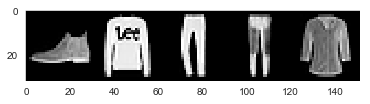

In [34]:
fmnist_sample = iter(test_loader).next()
fmnist_sample[0] = fmnist_sample[0].to(DEVICE)
print(fmnist_sample[1])
sns.set_style("dark")
show(make_grid(fmnist_sample[0].cpu()))

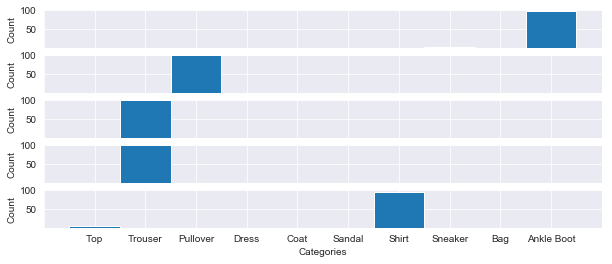

In [35]:
net.eval()
fmnist_outputs = net(fmnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy()
for _ in range(99):
    fmnist_outputs = np.append(fmnist_outputs, net(fmnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy(), axis=1)
sns.set_style("darkgrid")
plt.subplots(5,1,figsize=(10,4))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.ylim(0,100)
    plt.xlabel("Categories")
    plt.xticks(range(10), ["Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
    plt.ylabel("Count")
    plt.yticks(range(50,101,50))
    plt.hist(fmnist_outputs[i], np.arange(-0.5, 10, 1))

In [36]:
mnist_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist', train=False, download=True, transform=transforms.ToTensor()), batch_size=5, shuffle=False)

Processing...
Done!


tensor([7, 2, 1, 0, 4])


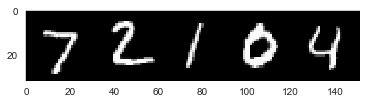

In [37]:
mnist_sample = iter(mnist_loader).next()
mnist_sample[0] = mnist_sample[0].to(DEVICE)
print(mnist_sample[1])
sns.set_style("dark")
show(make_grid(mnist_sample[0].cpu()))

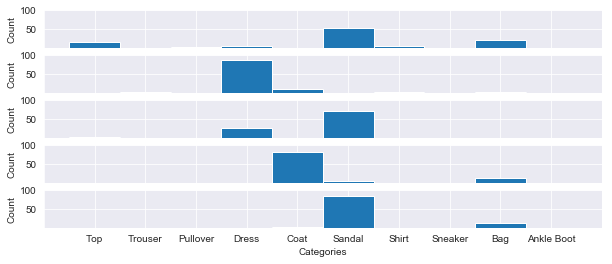

In [38]:
net.eval()
mnist_outputs = net(mnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy()
for _ in range(99):
    mnist_outputs = np.append(mnist_outputs, net(mnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy(), axis=1)

sns.set_style("darkgrid")
plt.subplots(5,1,figsize=(10,4))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.ylim(0,100)
    plt.xlabel("Categories")
    plt.xticks(range(10), ["Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
    plt.ylabel("Count")
    plt.yticks(range(50,101,50))
    plt.hist(mnist_outputs[i], np.arange(-0.5, 10, 1))